# Find the optimum Rotation of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne et Jérémy Neveu
- affiliation : LAL/IN2P3/CNRS, France
- date   : May 29th 2017
- update : May 31st 2017


- The goal is to rotate the image correctly such the dispersive axis must be parallel to X.
Carefull check must be done with eye such the fit of the Y vs X line is correct without bias.
This can be done on every image. Another solution is to force the value of the rotation angle
if one is sure of it.
- So One must decide if he want one average rotation angle or one rotation angle for each image.
Not sure.
- An Hessian method used to detect filaments in maps has been adapted to detect the spectra and 
compute their rotation angles

In [5]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [6]:
print theNotebook

FindOptRot


In [7]:
%matplotlib inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os, sys
sys.path.append('../../common_tools')
from scan_holo import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [9]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from matplotlib import cm

In [10]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [11]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [12]:
%load_ext Cython

In [13]:
from IPython.display import Image, display

In [14]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [15]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [16]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)

In [17]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [18]:
ensure_dir(dir_top_images) # create that directory

### input directory of fits images

In [19]:
inputdir="cut_fitsimages"
MIN_IMGNUMBER=183
MAX_IMGNUMBER=207
holo_name = 'Thor300'
object_name='HD111980 June 9th 2017'
SelectTagRe='^cutimg_20170609_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^cutimg_20170609_[0-9]+.fits$'
NBIMGPERROW=4

### output directory of fits images

In [20]:
outputdir="./rotated_fitsimages"

In [21]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [22]:
input_filelist=os.listdir(inputdir) 

In [23]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [24]:
print input_filelist

['cutimg_20170609_183.fits' 'cutimg_20170609_184.fits'
 'cutimg_20170609_185.fits' 'cutimg_20170609_186.fits'
 'cutimg_20170609_187.fits' 'cutimg_20170609_188.fits'
 'cutimg_20170609_189.fits' 'cutimg_20170609_190.fits'
 'cutimg_20170609_191.fits' 'cutimg_20170609_192.fits'
 'cutimg_20170609_193.fits' 'cutimg_20170609_194.fits'
 'cutimg_20170609_195.fits' 'cutimg_20170609_196.fits'
 'cutimg_20170609_197.fits' 'cutimg_20170609_198.fits'
 'cutimg_20170609_199.fits' 'cutimg_20170609_200.fits'
 'cutimg_20170609_201.fits' 'cutimg_20170609_202.fits'
 'cutimg_20170609_203.fits' 'cutimg_20170609_204.fits'
 'cutimg_20170609_205.fits' 'cutimg_20170609_206.fits'
 'cutimg_20170609_207.fits' 'star_centroids.txt']


In [25]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [26]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall(SelectTagRe,file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

    


In [27]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [28]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [29]:
print indexes_files

[183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207]


In [30]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [31]:
sorted_numbers=indexes_files[sorted_indexes]

In [32]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [33]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [34]:
#sorted_files

## Build full filename
----------------------------

In [35]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [36]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [37]:
print sorted_filenames.shape

(25,)


## Acces to data of  images
----------------------------------

In [38]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [39]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        filters = header['FILTERS']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt

In [40]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [41]:
len(all_images)

25

In [42]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

global NBIMGPERROW
    
def ShowImages(all_images,all_titles,object_name,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=4
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,3*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        xprofile=np.sum(all_images[index],axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=-10,vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
    title='Images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)  
    return thex0

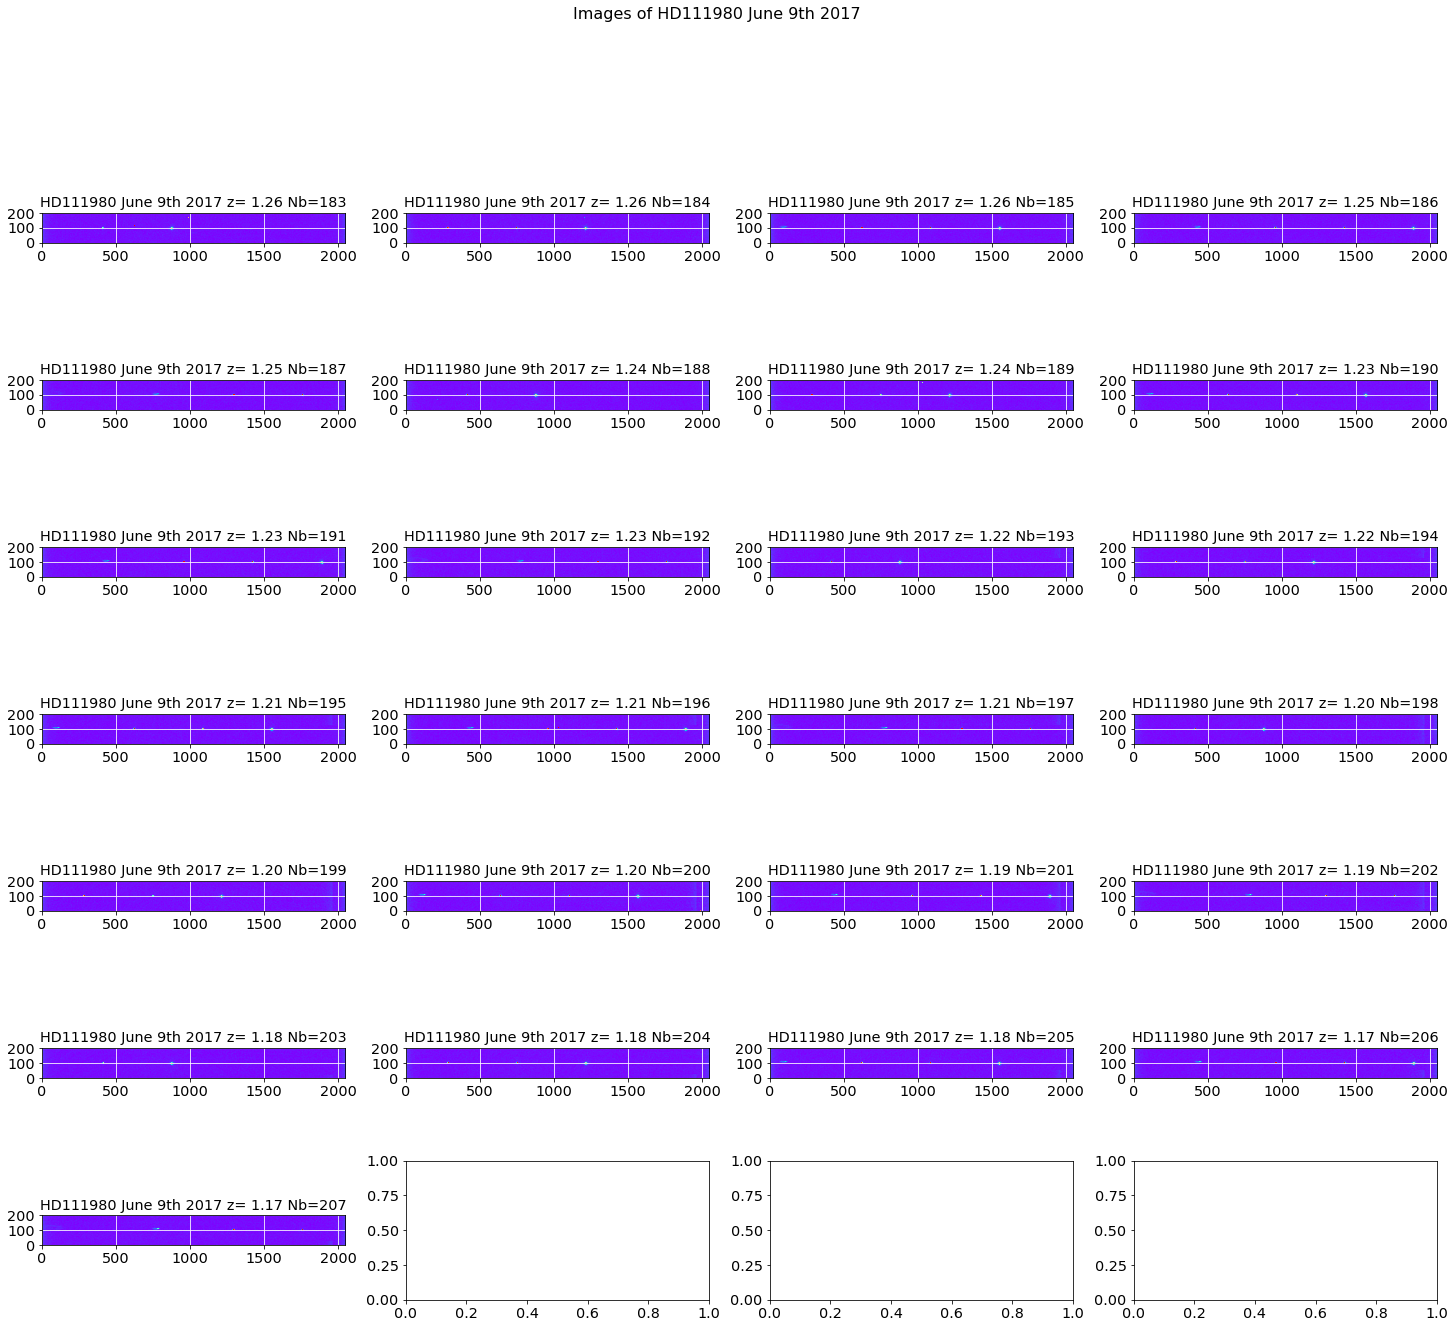

In [43]:
thex0=ShowImages(all_images,all_titles,object_name,dir_top_images)

## Duplicate the images

In [44]:
all_images2=[]
for image in all_images:
    image_copy=np.copy(image)
    all_images2.append(image_copy)


## Subtract Background

In [45]:
for theimage in all_images2:
    NR,NC=theimage.shape
    EmptySkyBackground=np.zeros([NR,NC])
    SkyBackground=EmptySkyBackground+np.median(theimage,axis=0)
    theimage-=SkyBackground

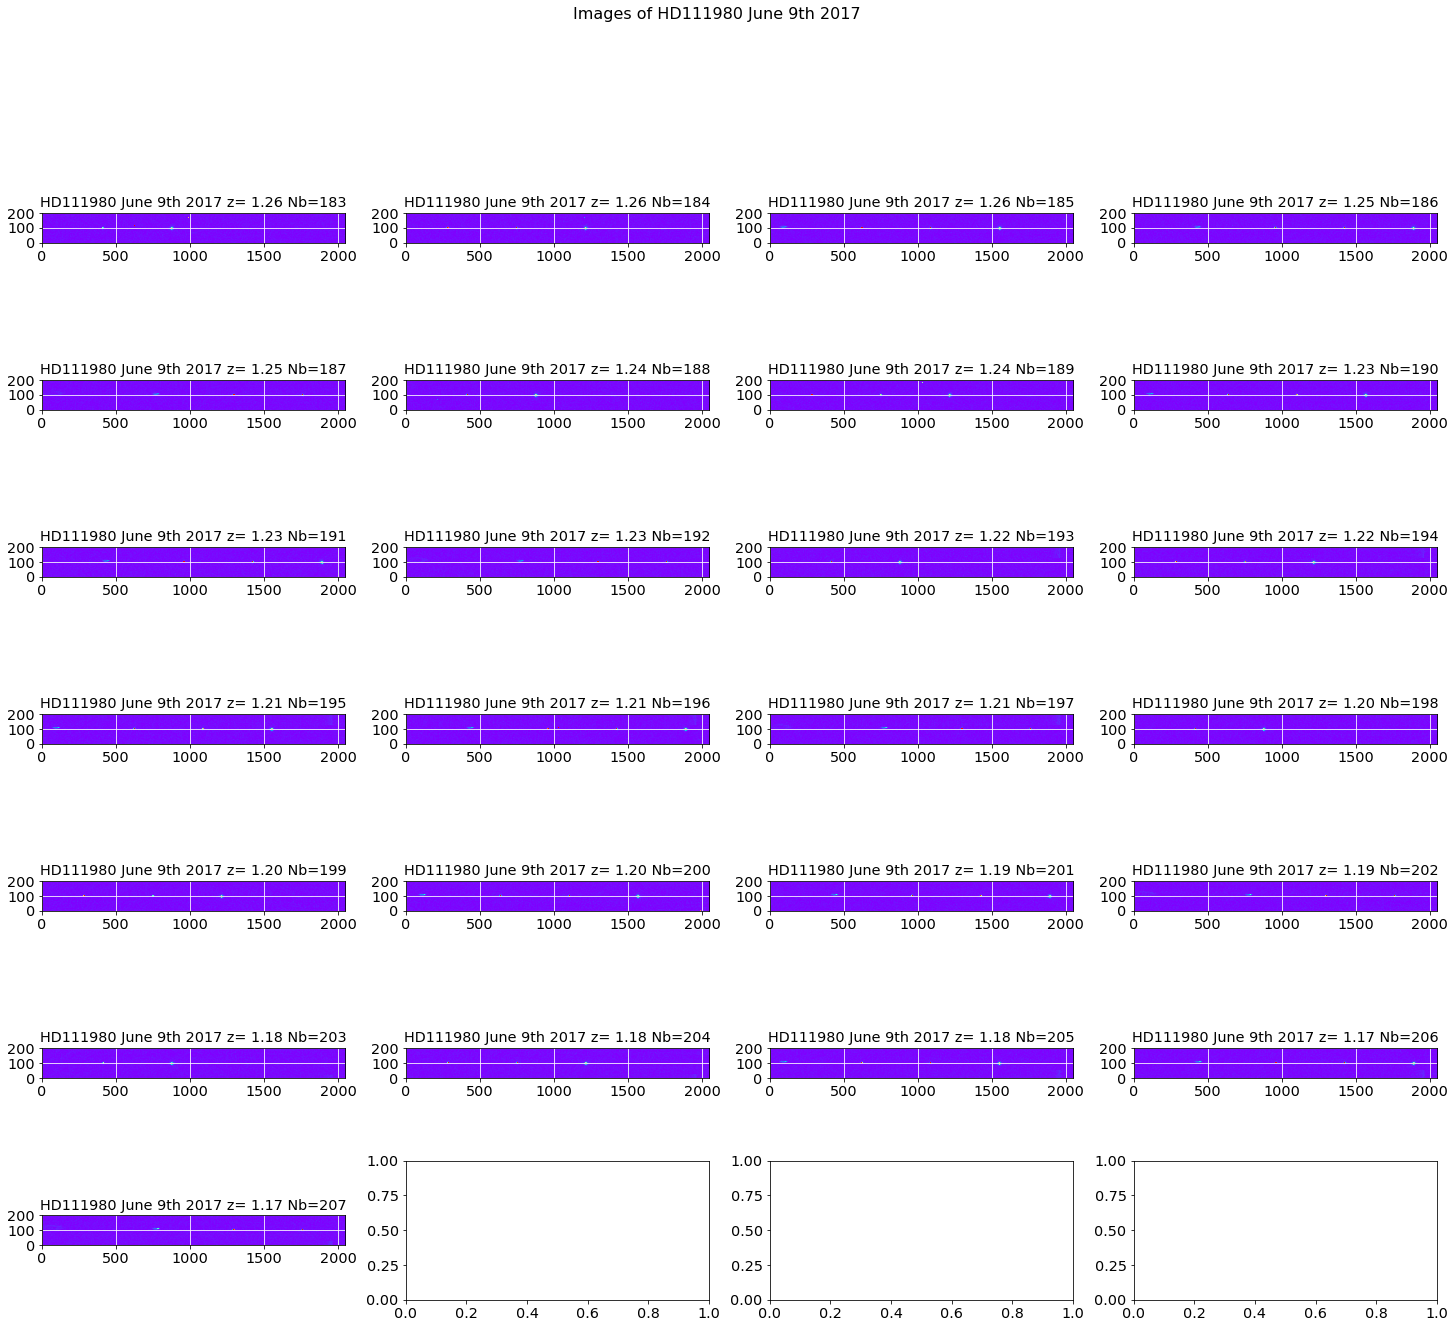

In [46]:
thex02=ShowImages(all_images2,all_titles,object_name,dir_top_images)

### Shows the transverse profile

In [47]:
DeltaX=600
w=20
ws=80

In [48]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
import os


def ShowTransverseProfile(all_images,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowTransverseProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=4
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    DeltaX=600
    w=20
    ws=80
    thespectra= []
    they0= []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        data=np.copy(all_images[index])
        data[:,DeltaX-ws:DeltaX+ws]=0
        if(all_expo[index]<=0):
            yprofile=np.sum(data,axis=1)  #very special case
        else:
            yprofile=np.sum(data,axis=1)/all_expo[index]
        ymin=1
        ymax=yprofile.max()
        y0=np.where(yprofile==ymax)[0][0]
        they0.append(y0)
        #im=axarr[iy,ix].imshow(data,vmin=-10,vmax=50)
        axarr[iy,ix].semilogy(yprofile)
        axarr[iy,ix].semilogy([y0,y0],[ymin,ymax],'r-')
        axarr[iy,ix].semilogy([y0-w,y0-w],[ymin,ymax],'k-')
        axarr[iy,ix].semilogy([y0+w,y0+w],[ymin,ymax],'k-')
        axarr[iy,ix].set_ylim(1000.,2e5)
        spectrum2D=np.copy(data[y0-w:y0+w,:])
        xprofile=np.sum(spectrum2D,axis=0)
        thespectra.append(xprofile/(2.*float(w))/all_expo[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    title='Spectrum tranverse profile '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'transverse_profile.pdf')
    plt.savefig(figfilename)  
    return thespectra,they0

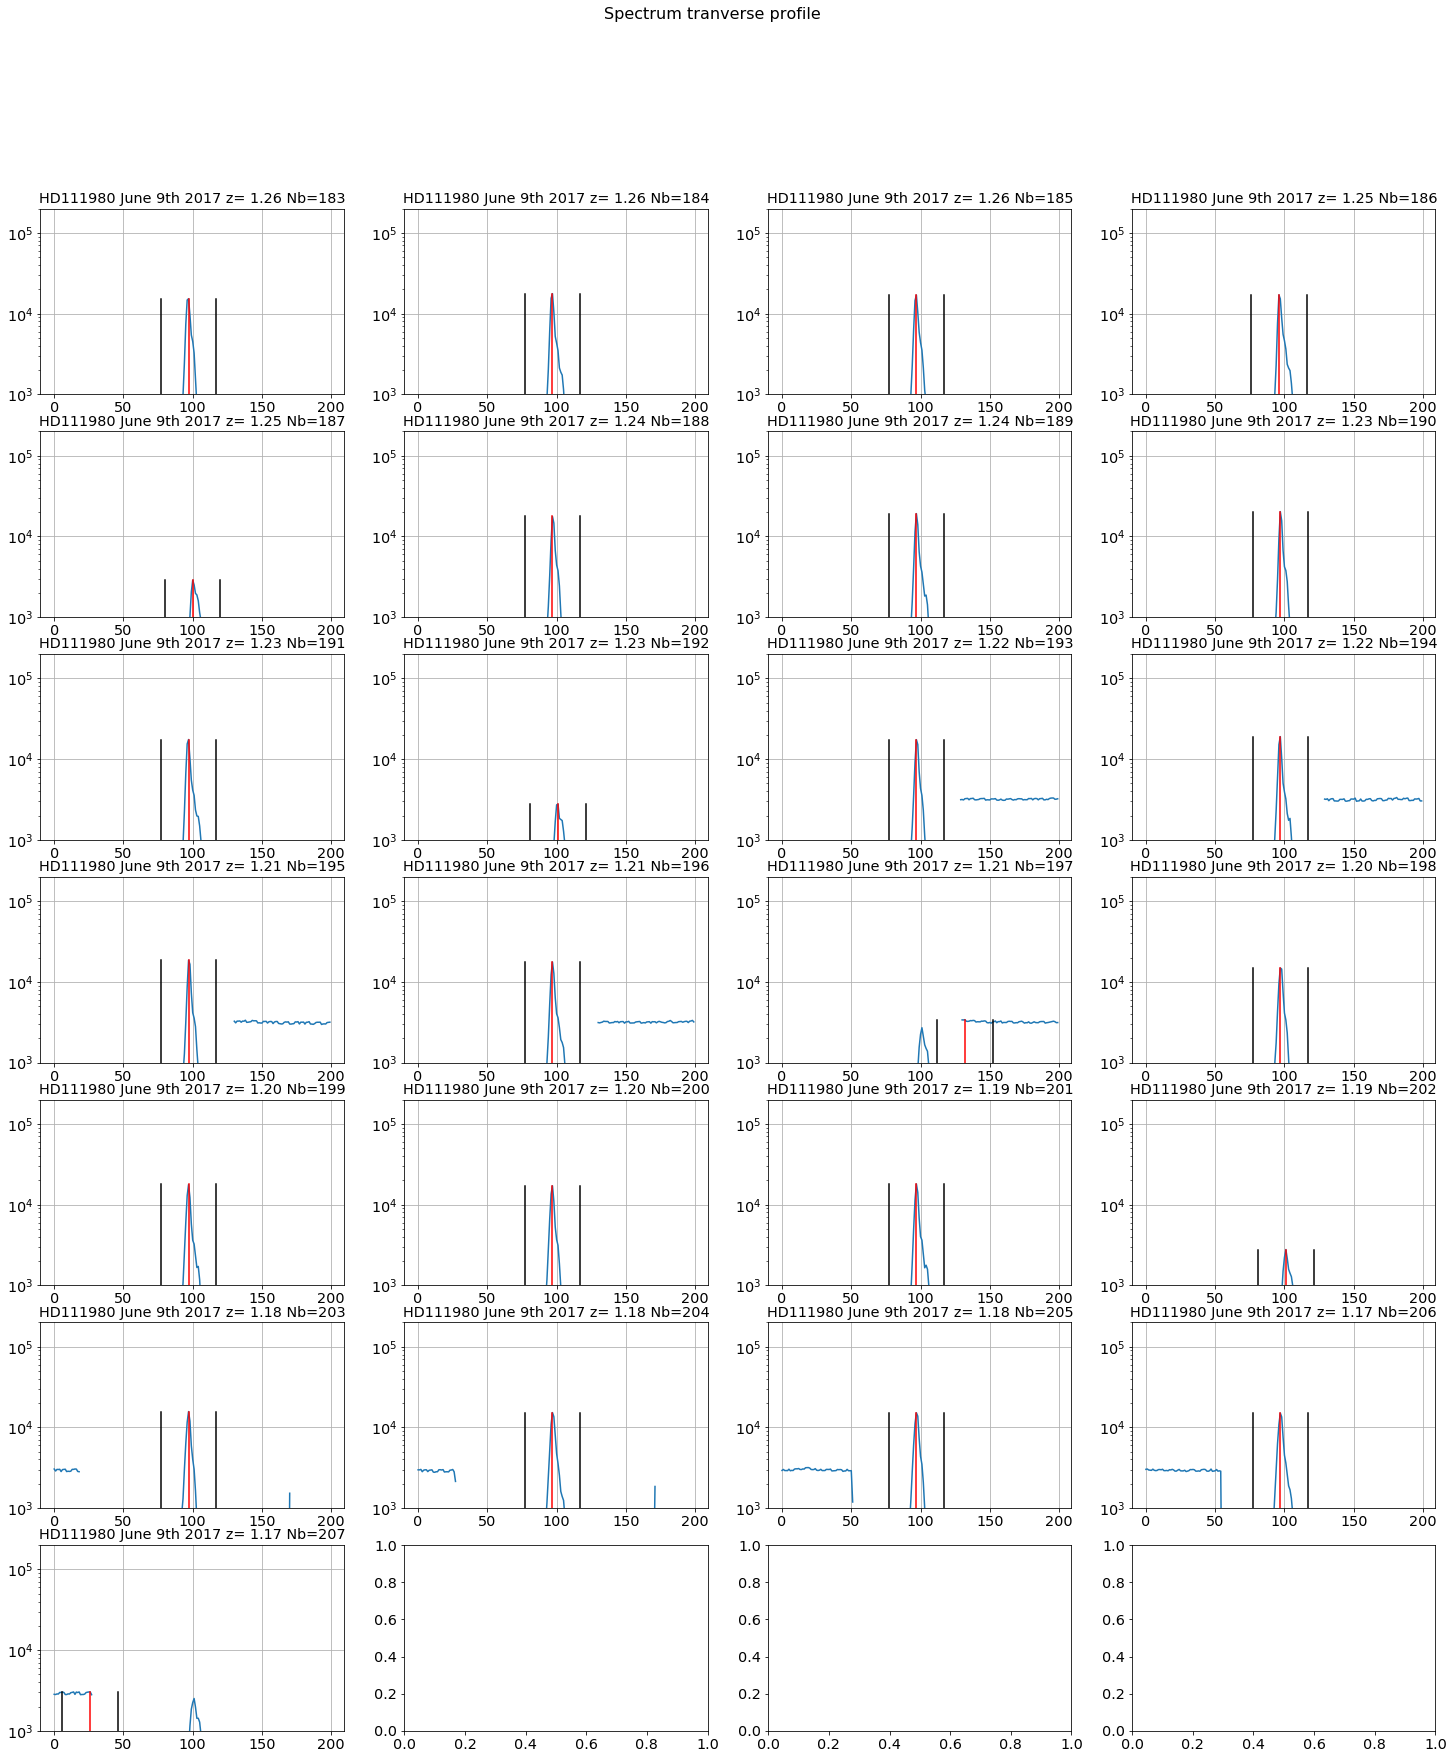

In [204]:
thespectra,they0=ShowTransverseProfile(all_images2,all_titles,object_name,all_expo,dir_top_images)

In [50]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
def ShowSpectrumProfile(spectra,all_titles,object_name,dir_top_images):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=4
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,200.)
    title='Spectrum 1D profile '.format(object_name)
    figfilename=os.path.join(dir_top_images,'longitudinal_profile.pdf')
    plt.savefig(figfilename)  
    plt.suptitle(title,size=16)

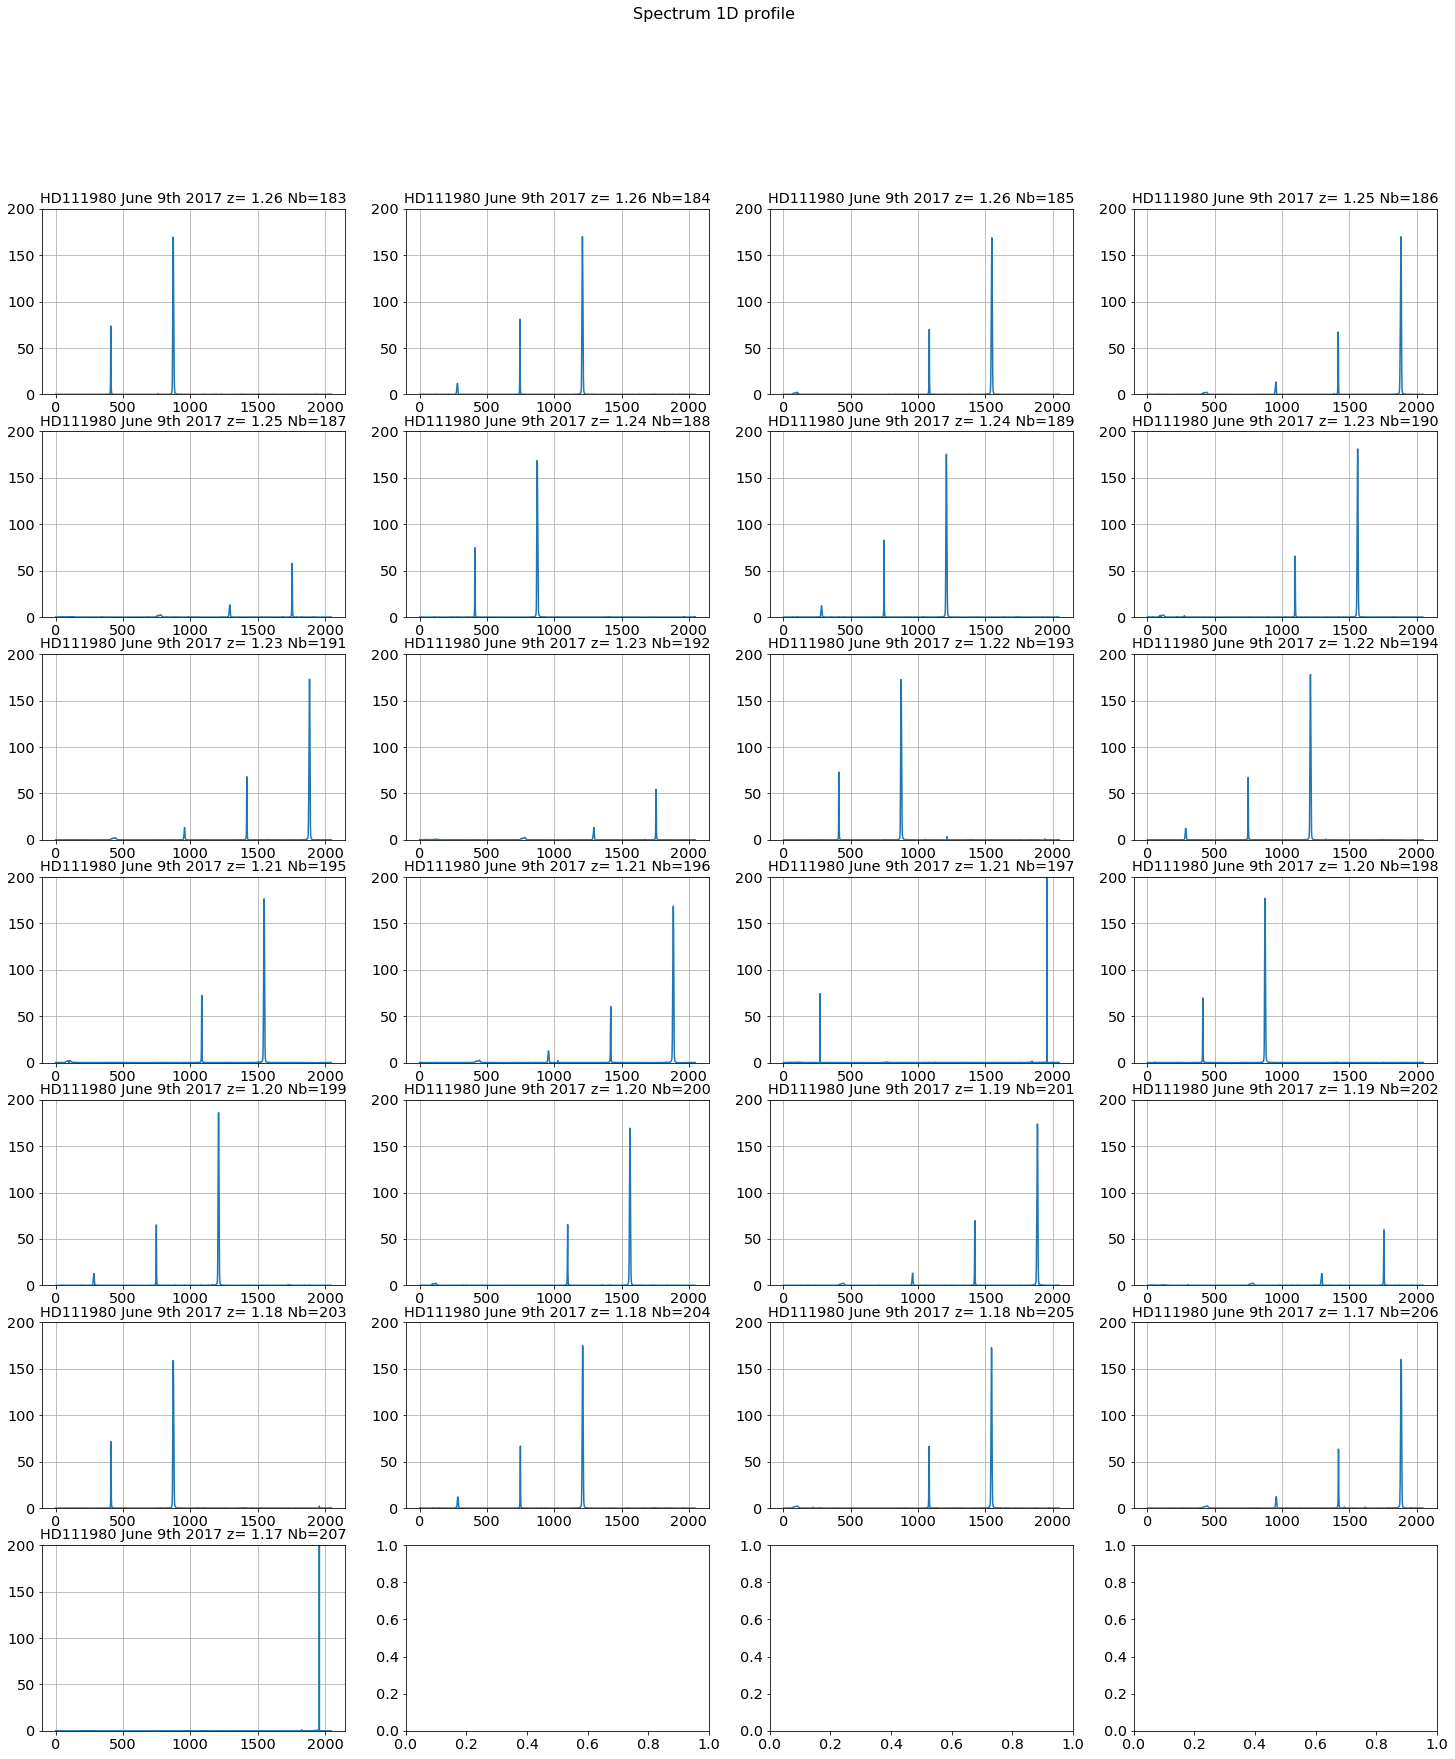

In [51]:
ShowSpectrumProfile(thespectra,all_titles,object_name,dir_top_images)

In [52]:
print they0

[97, 97, 97, 96, 100, 97, 97, 97, 97, 101, 97, 97, 97, 97, 132, 97, 97, 97, 97, 101, 97, 97, 97, 97, 26]


In [53]:
print thex0

[873, 1210, 1547, 1883, 1757, 874, 1210, 1561, 1885, 1756, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958]


Les positions thex0 et they0 sont fausses à cause d'une colonne morte. On charge les centroids de l'étape précédente.

In [206]:
textfilename = os.path.join(inputdir,'star_centroids.txt')
central_positions = np.loadtxt(textfilename)

thex0 = central_positions.T[1].astype(int)
they0 = 100*np.ones_like(thex0)
print thex0
print they0

[ 409  745 1082 1417 1756  411  747 1097 1420 1756  411  748 1084 1419 1755
  411  747 1099 1420 1756  411  748 1081 1419 1753]
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100]


### Test rotation optimum
----------------------------

In [194]:
from scipy import stats 
from scipy import ndimage
from scipy.optimize import curve_fit

In [207]:
sel=14

In [208]:
image_sel=np.copy(all_images2[sel])
y0=they0[sel]
x0=thex0[sel]
xindex=np.arange(image_sel.shape[1])

### Find rotation by Hessian analysis

La méthode s'inspire des techniques de détection de filmanents dans le milieu interstellaire.
Elle est décrite dans https://arxiv.org/pdf/1409.6728.pdf section 4.1.
Documentation sur le calcul du Hessien : http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hessian_matrix

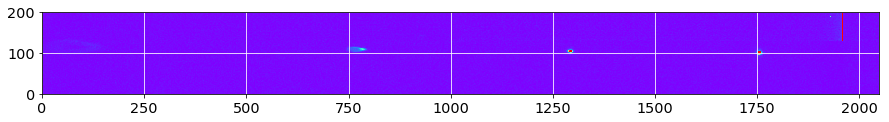

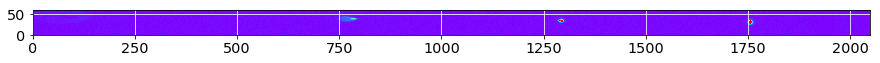

In [209]:
width_cut = 30

plt.imshow(image_sel,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

region=np.copy(image_sel[y0-width_cut:y0+width_cut,:])
data=np.copy(region)
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()

In [210]:
from skimage.feature import hessian_matrix
# le paramètre sigma permet de lisser le hessien
Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi

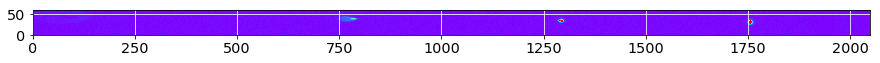

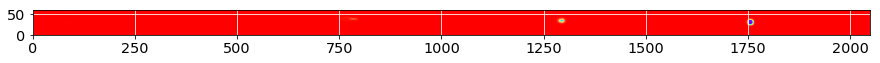

In [211]:
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()
plt.imshow(lambda_minus,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='white', ls='solid')
plt.show()

Maintenant on va sélectionner le spectre à l'aide d'un seuil pour éliminer le fond.

Number of remaining pixels : 988


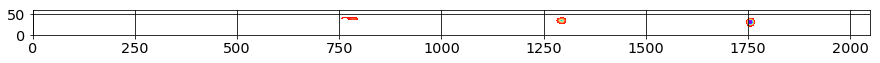

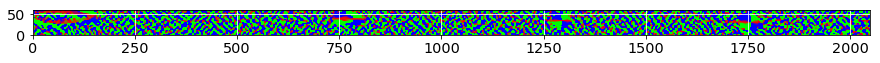

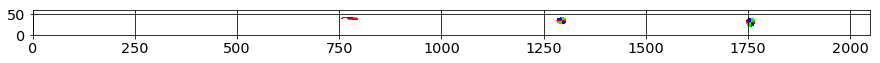

In [212]:
lambda_threshold = -2

mask = np.where(lambda_minus>lambda_threshold)
lambda_mask = np.copy(lambda_minus)
lambda_mask[mask]=np.nan

theta_mask = np.copy(theta)
theta_mask[mask]=np.nan

print 'Number of remaining pixels :',len(lambda_mask[~np.isnan(lambda_mask)])

plt.imshow(lambda_mask,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='black', ls='solid')
plt.show()

plt.imshow(theta,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='white', ls='solid')
plt.show()

plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.grid(color='black', ls='solid')
plt.show()

On sait que l'angle que l'on recherche est petit car l'axe de dispersion du réseau est bien aligné selon x, donc on peut sélectionner.

Number of remaining pixels : 370


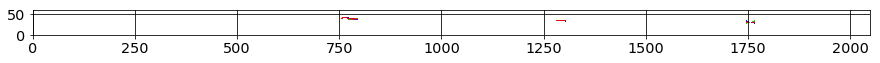

In [213]:
deg_threshold = 20

mask2 = np.where(np.abs(theta)>deg_threshold)
theta_mask[mask2] = np.nan
print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
plt.grid(color='black', ls='solid')
plt.show()

Angle median : -1.45052418531


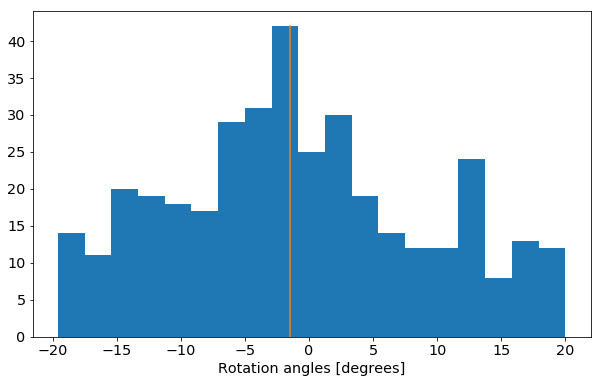

In [214]:
theta_hist = []
theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
theta_median = np.median(theta_hist)
print 'Angle median :',theta_median
fig = plt.figure(figsize=(10,6))
n,bins, patches = plt.hist(theta_hist,bins=int(np.sqrt(len(theta_hist))))
plt.plot([theta_median,theta_median],[0,np.max(n)])
plt.xlabel("Rotation angles [degrees]")
plt.show()

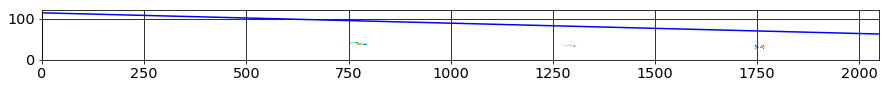

In [215]:
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = y0 - width_cut + (x_new-x0)*np.tan(theta_median*np.pi/180.)
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()

On peut aussi essayer de fitter le spectre qui a été détecté par la méthode ci-dessus.

Rotation angle from fit : -0.546896911902


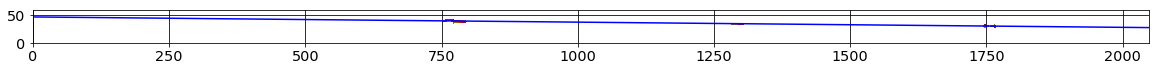

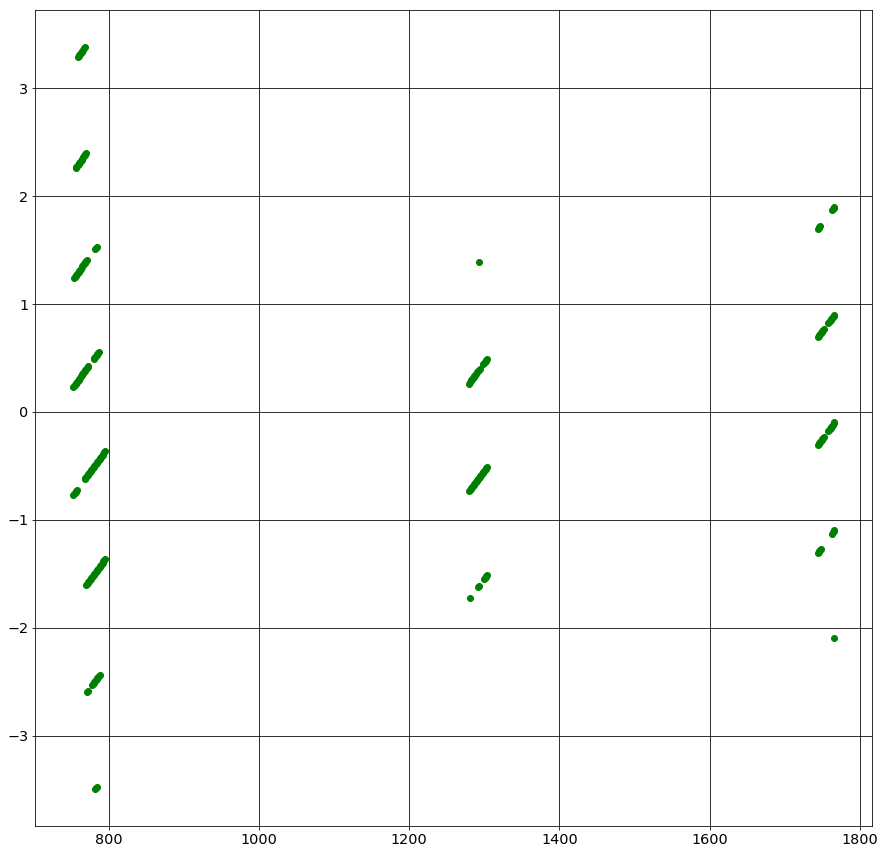

In [216]:
def fit_func(x, a, b):
    return a*x + b

xtofit=[]
ytofit=[]
for iy,y in enumerate(theta_mask):
    for ix,x in enumerate(y):
        if not np.isnan(theta_mask[iy][ix]) :
            if np.abs(theta_mask[iy][ix])>12 : continue
            xtofit.append(ix)
            ytofit.append(iy)
params = curve_fit(fit_func, xtofit, ytofit)
[a, b] = params[0]
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = fit_func(x_new,a,b)
print 'Rotation angle from fit :',np.arctan(a)*180/np.pi
fig = plt.figure(figsize=[20,30])
plt.imshow(theta_mask,origin='lower',cmap=cm.brg,vmin=-30,vmax=30)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()
diff = []
for ix,x in enumerate(xtofit):
    diff.append(ytofit[ix]-fit_func(x,a,b))
plt.plot(xtofit,diff,'go')
plt.grid(color='black', ls='solid')
plt.show()

Je pense que la méthode de fit est adapté aux spectres de raies.

## Find Rotation angle for each image
----------------------------------------------

In [217]:
def ComputeRotationAngleHessian(all_images,thex0,they0,all_titles,object_name):
    """
    ComputeRotationAngle
    ====================
    
    input:
    ------
    all_images
    thex0
    they0
    all_titles
    object_name
    
    output:
    ------
    rotation angles
    
    """
    NBIMAGES=len(all_images)
    NBIMGPERROW=2
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    
    param_theta=np.zeros(NBIMAGES)
    
    ####### PARAMETERS TO BE TUNED #########
    lambda_threshold = -2
    deg_threshold = 20
    width_cut = 40
    ########################################

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,2*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        
        image_sel=np.copy(image)
        y0=they0[index]
        x0=thex0[index]
        
        # extract a region of 200 x 1000 centered at y=100,x=500
        
        region=np.copy(image_sel[y0-width_cut:y0+width_cut,:])
        data=np.copy(region)
        
        # compute hessian matrices on the image
        
        Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
        lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
        lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
                

        mask = np.where(lambda_minus>lambda_threshold)
        #lambda_mask = np.copy(lambda_minus)
        #lambda_mask[mask]=np.nan

        theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi
        theta_mask = np.copy(theta)
        theta_mask[mask]=np.nan

        mask2 = np.where(np.abs(theta)>deg_threshold)
        theta_mask[mask2] = np.nan
        
        theta_hist = []
        theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
        theta_median = np.median(theta_hist)
        
        param_theta[index] = theta_median
        
        x_new = np.linspace(xindex.min(),xindex.max(), 50)
        y_new = width_cut + (x_new-x0)*np.tan(theta_median*np.pi/180.)
    
        im=axarr[iy,ix].imshow(theta_mask,origin='lower',aspect='auto',cmap=cm.brg,vmin=-deg_threshold,vmax=deg_threshold)
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        
        axarr[iy,ix].set_ylim(0,2*width_cut)
        axarr[iy,ix].grid(True)
        

    title='Fit rotation angle of '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
    plt.savefig(figfilename)  
    
    
    return param_theta
    

In [222]:
def ComputeRotationAngleHessianAndFit(all_images,thex0,they0,all_titles,object_name):
    """
    ComputeRotationAngle
    ====================
    
    input:
    ------
    all_images
    thex0
    they0
    all_titles
    object_name
    
    output:
    ------
    rotation angles
    
    """
    NBIMAGES=len(all_images)
    NBIMGPERROW=2
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    
    param_theta=np.zeros(NBIMAGES)
    
    ####### PARAMETERS TO BE TUNED #########
    lambda_threshold = -2
    deg_threshold = 20
    width_cut = 20
    left_w = 1400
    right_w = 1400
    ########################################

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,2*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        
        image_sel=np.copy(image)
        y0=they0[index]
        x0=thex0[index]
        
        # extract a region centered on order 0
        
        region=np.copy(image_sel[y0-width_cut:y0+width_cut,max(0,x0-left_w):min(IMSIZE,x0+right_w)])
        data=np.copy(region)
        
        # compute hessian matrices on the image
        
        Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
        lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
        lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
                

        mask = np.where(lambda_minus>lambda_threshold)
        #lambda_mask = np.copy(lambda_minus)
        #lambda_mask[mask]=np.nan

        theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi
        theta_mask = np.copy(theta)
        theta_mask[mask]=np.nan
        #print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)]),' Index=',index

        mask2 = np.where(np.abs(theta)>deg_threshold)
        theta_mask[mask2] = np.nan
        
        #print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)]),' Index=',index

        #theta_hist = []
        #theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
        #theta_median = np.median(theta_hist)
        
        xtofit=[]
        ytofit=[]
        for ky,y in enumerate(theta_mask):
            for kx,x in enumerate(y):
                if not np.isnan(theta_mask[ky][kx]) :
                    if np.abs(theta_mask[ky][kx])>deg_threshold : continue
                    xtofit.append(kx)
                    ytofit.append(ky)
        params = curve_fit(fit_func, xtofit, ytofit)
        [a, b] = params[0]
        x_new = np.linspace(max(0,x0-left_w),min(IMSIZE,x0+right_w), 50)
        y_new = fit_func(x_new,a,b)
        
        param_theta[index] = np.arctan(a)*180/np.pi
        
        im=axarr[iy,ix].imshow(theta_mask,origin='lower',cmap=cm.brg,aspect='auto',vmin=-deg_threshold,vmax=deg_threshold)
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        
        axarr[iy,ix].set_ylim(0,2*width_cut)
        axarr[iy,ix].grid(True)
        

    title='Fit rotation angle of '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
    plt.savefig(figfilename)  
    
    
    return param_theta
    

0  theta =  -0.53348634707 	x0 =  409.0 	y0 =  330.0
1  theta =  -0.442761953811 	x0 =  745.0 	y0 =  330.0
2  theta =  -0.363850156552 	x0 =  1082.0 	y0 =  329.0
3  theta =  -0.37246005156 	x0 =  1417.0 	y0 =  330.0
4  theta =  -0.301208957636 	x0 =  1756.0 	y0 =  330.0
5  theta =  -0.438763933916 	x0 =  411.0 	y0 =  663.0
6  theta =  -0.442438222346 	x0 =  747.0 	y0 =  662.0
7  theta =  -0.412608450639 	x0 =  1097.0 	y0 =  661.0
8  theta =  -0.40890024372 	x0 =  1420.0 	y0 =  661.0
9  theta =  -0.362076477829 	x0 =  1756.0 	y0 =  662.0
10  theta =  -0.533262289085 	x0 =  411.0 	y0 =  995.0
11  theta =  -0.440727022426 	x0 =  748.0 	y0 =  995.0
12  theta =  -0.480051242175 	x0 =  1084.0 	y0 =  994.0
13  theta =  -0.481632456791 	x0 =  1419.0 	y0 =  994.0
14  theta =  -0.538655054129 	x0 =  1755.0 	y0 =  994.0
15  theta =  -0.446869813437 	x0 =  411.0 	y0 =  1332.0
16  theta =  -0.444862118929 	x0 =  747.0 	y0 =  1331.0
17  theta =  -0.51865199662 	x0 =  1099.0 	y0 =  1330.0
18  theta =

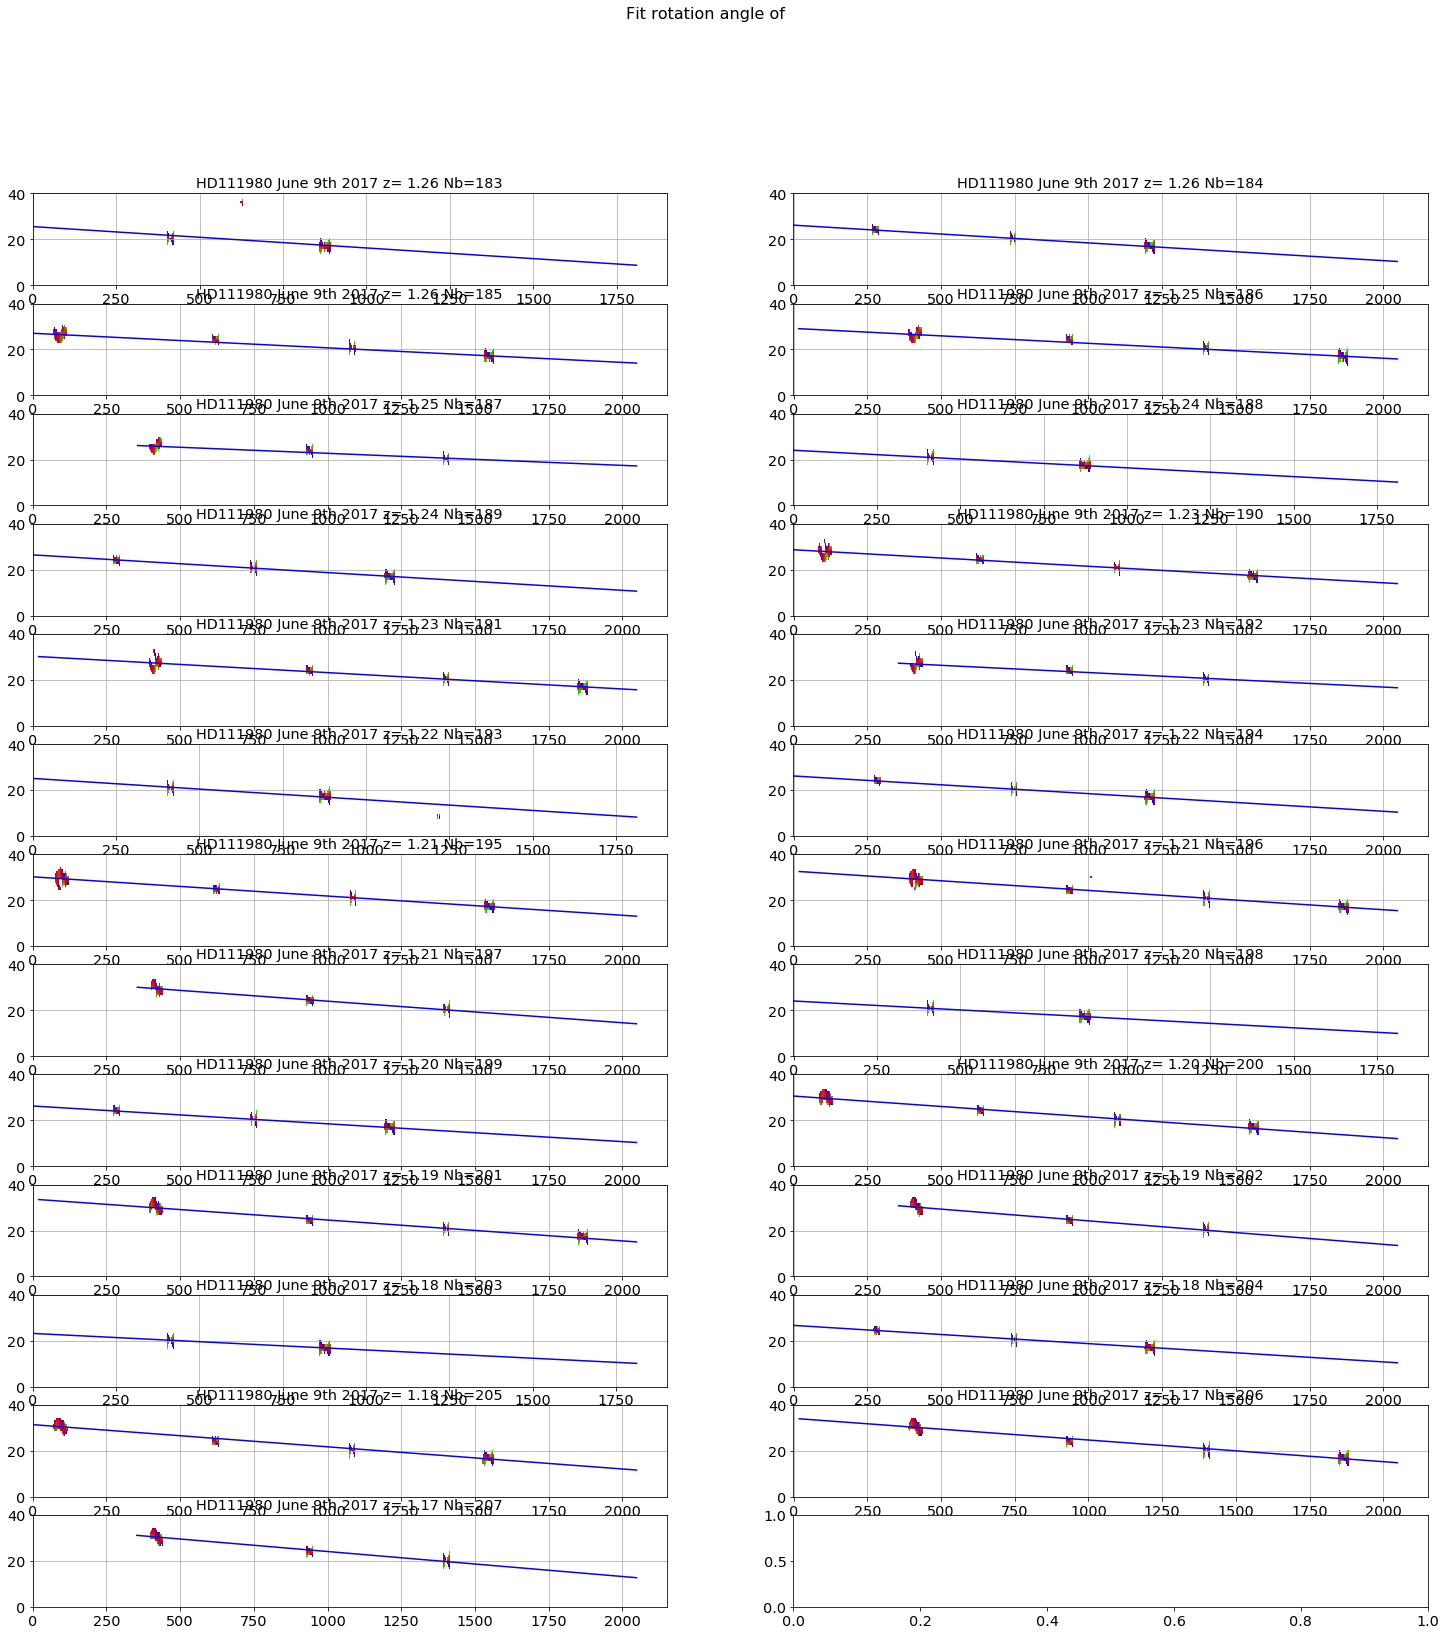

In [223]:
all_theta=ComputeRotationAngleHessianAndFit(all_images2,thex0,they0,all_titles,object_name)
for index in range(len(all_theta)):
    print index,' theta = ',all_theta[index], '\tx0 = ',central_positions[index][1], '\ty0 = ',central_positions[index][0]

### Choose here which rotation angle to apply

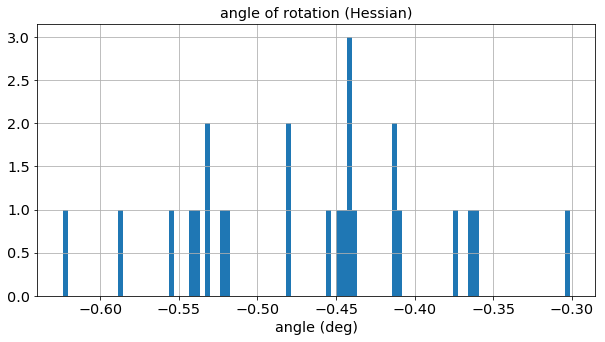

In [224]:
plt.figure(figsize=(10,5))
#hist(x, bins=10, range=None, normed=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, hold=None, data=None, **kwargs)
#n, bins, patches=plt.hist(all_angles,bins=50,range=[-1,.5],histtype='stepfilled')
n, bins, patches=plt.hist(all_theta,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation (Hessian)')
plt.xlabel('angle (deg)')

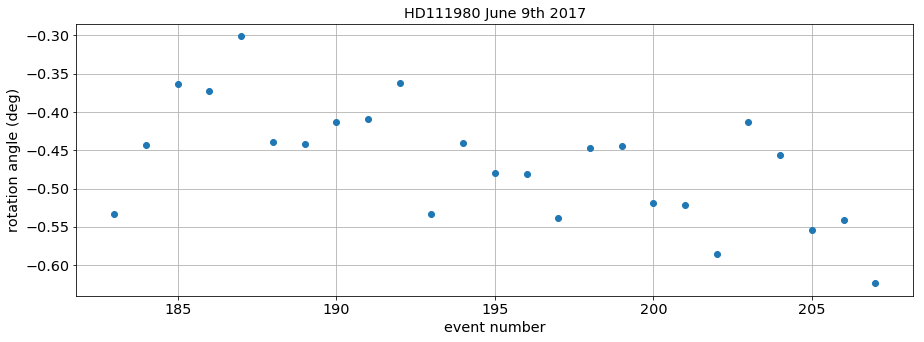

In [225]:
plt.figure(figsize=(15,5))
plt.plot(indexes_files,all_theta,'o')
plt.grid(True)
plt.ylabel('rotation angle (deg)')
plt.xlabel('event number')
plt.title(object_name)
figfilename=os.path.join(dir_top_images,'rotationvsevnum_hessian.pdf')
plt.savefig(figfilename) 

Avec la méthode Hessienne, on voit qu'on obtient des séries de 5 points : il y a un petit angle de rotation systématique aux bords du réseau : méthode ou réalité ?

## Now turn the images accordingly

In [226]:
def TurnTheImages(all_images,all_angles,all_titles,object_name,dir_top_images):
    """
    TurnTheImages
    =============
    
    input:
    ------
    all_images:
    all_angles:
    
    
    output:
    ------
    all_rotated_images
    
    """
    NBIMAGES=len(all_images)
    NBIMGPERROW=2
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    all_rotated_images = []

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,3*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        angle=all_angles[index]    
        data=np.copy(image)
        
        rotated_image=ndimage.interpolation.rotate(data,angle)
        
        all_rotated_images.append(rotated_image)
        
        im=axarr[iy,ix].imshow(rotated_image,origin='lower',cmap='rainbow',vmin=0,vmax=800)
        #im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        
        axarr[iy,ix].grid(True)
        
    title='Rotated images for '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'rotated_images.pdf')
    plt.savefig(figfilename)  
    
    return all_rotated_images

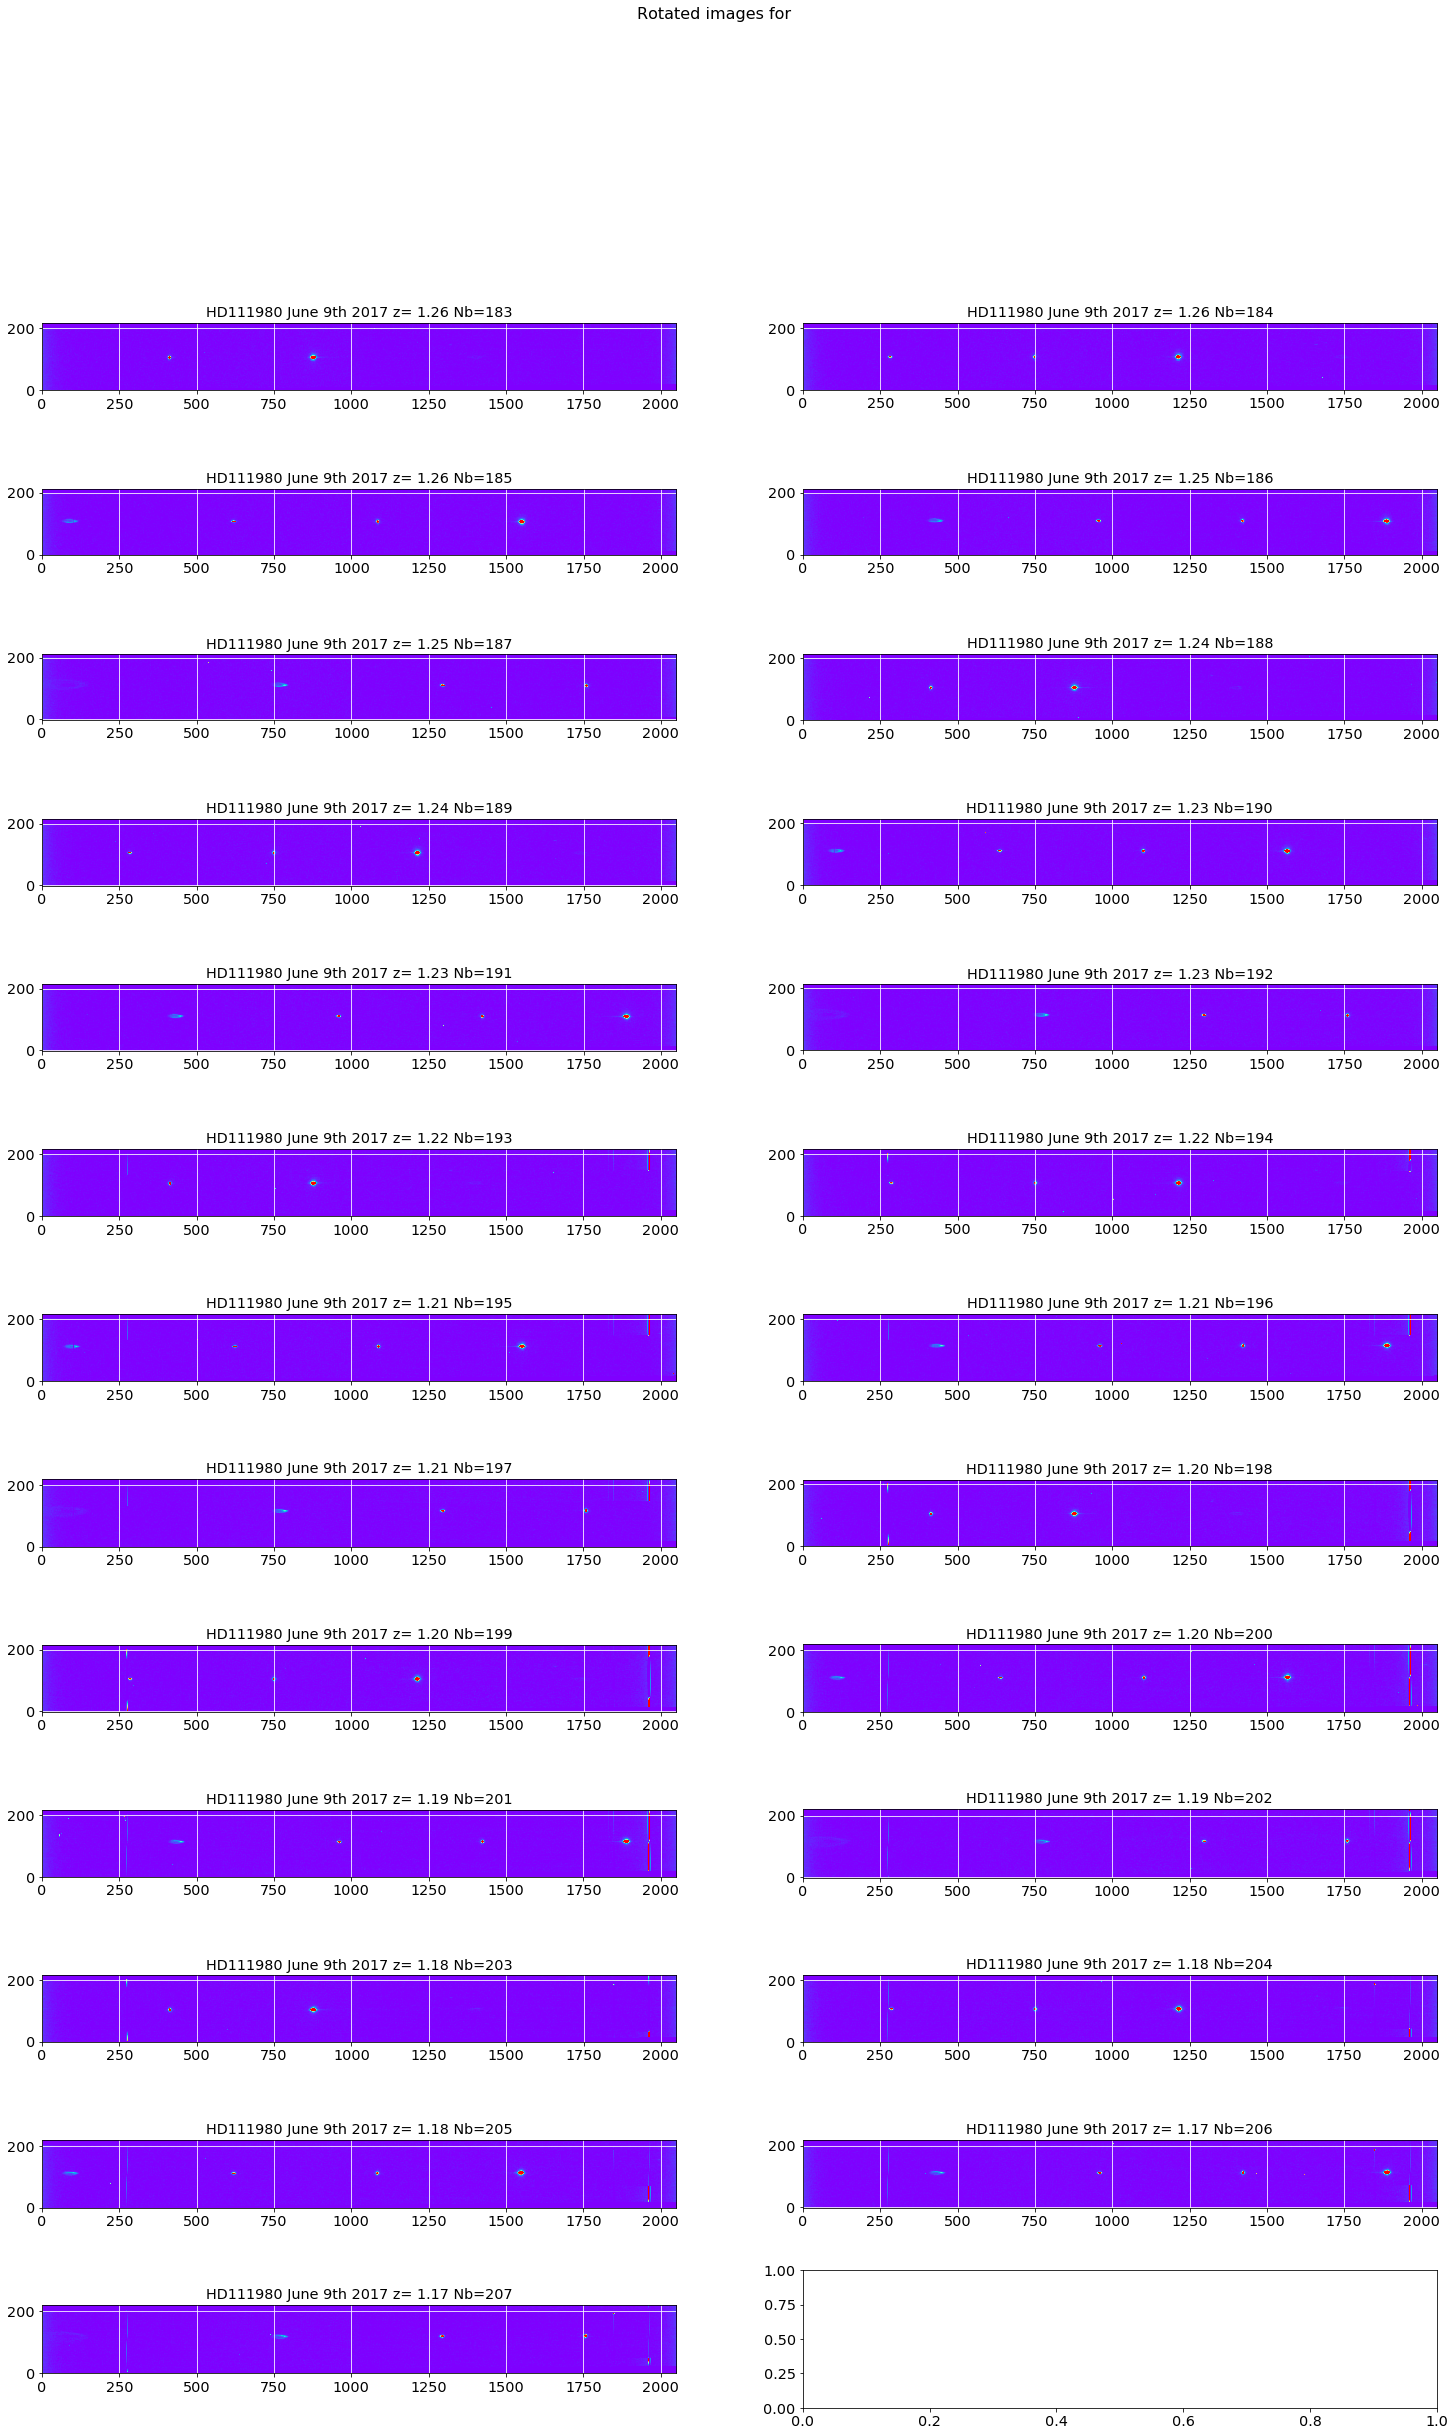

In [227]:
# J'utilise les angles qui viennent de la méthode Hessienne ici
turned_images=TurnTheImages(all_images,all_theta,all_titles,object_name,dir_top_images) #same rotation for each image

## Check rotation

In case of bad rotation, check by eye

In [228]:
sel=4

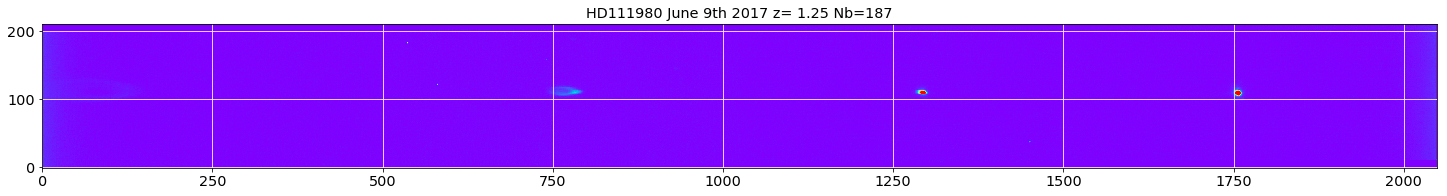

In [229]:
plt.figure(figsize=(25,10))
plt.imshow(turned_images[sel],origin='lower',cmap='rainbow',vmin=0,vmax=1000)
plt.grid(True)
plt.title(all_titles[sel])
plt.grid(color='white', ls='solid')
figfilename=os.path.join(dir_top_images,'rotated_image_sample.pdf')
plt.savefig(figfilename)  

array([-0.85069901, -0.39078792,  0.14813978,  0.42517647,  0.98840538,
       -0.85172229, -1.31675142, -0.79794183, -0.86162284, -0.61917435,
       -1.54910172, -1.00257532, -0.22123199, -0.26312331, -1.3854994 ,
       -0.06091724, -0.19398832,  0.23280147, -0.17837901, -1.0682492 ,
       -1.03654595, -1.50882604, -0.67574339, -0.95173481, -1.96741627])

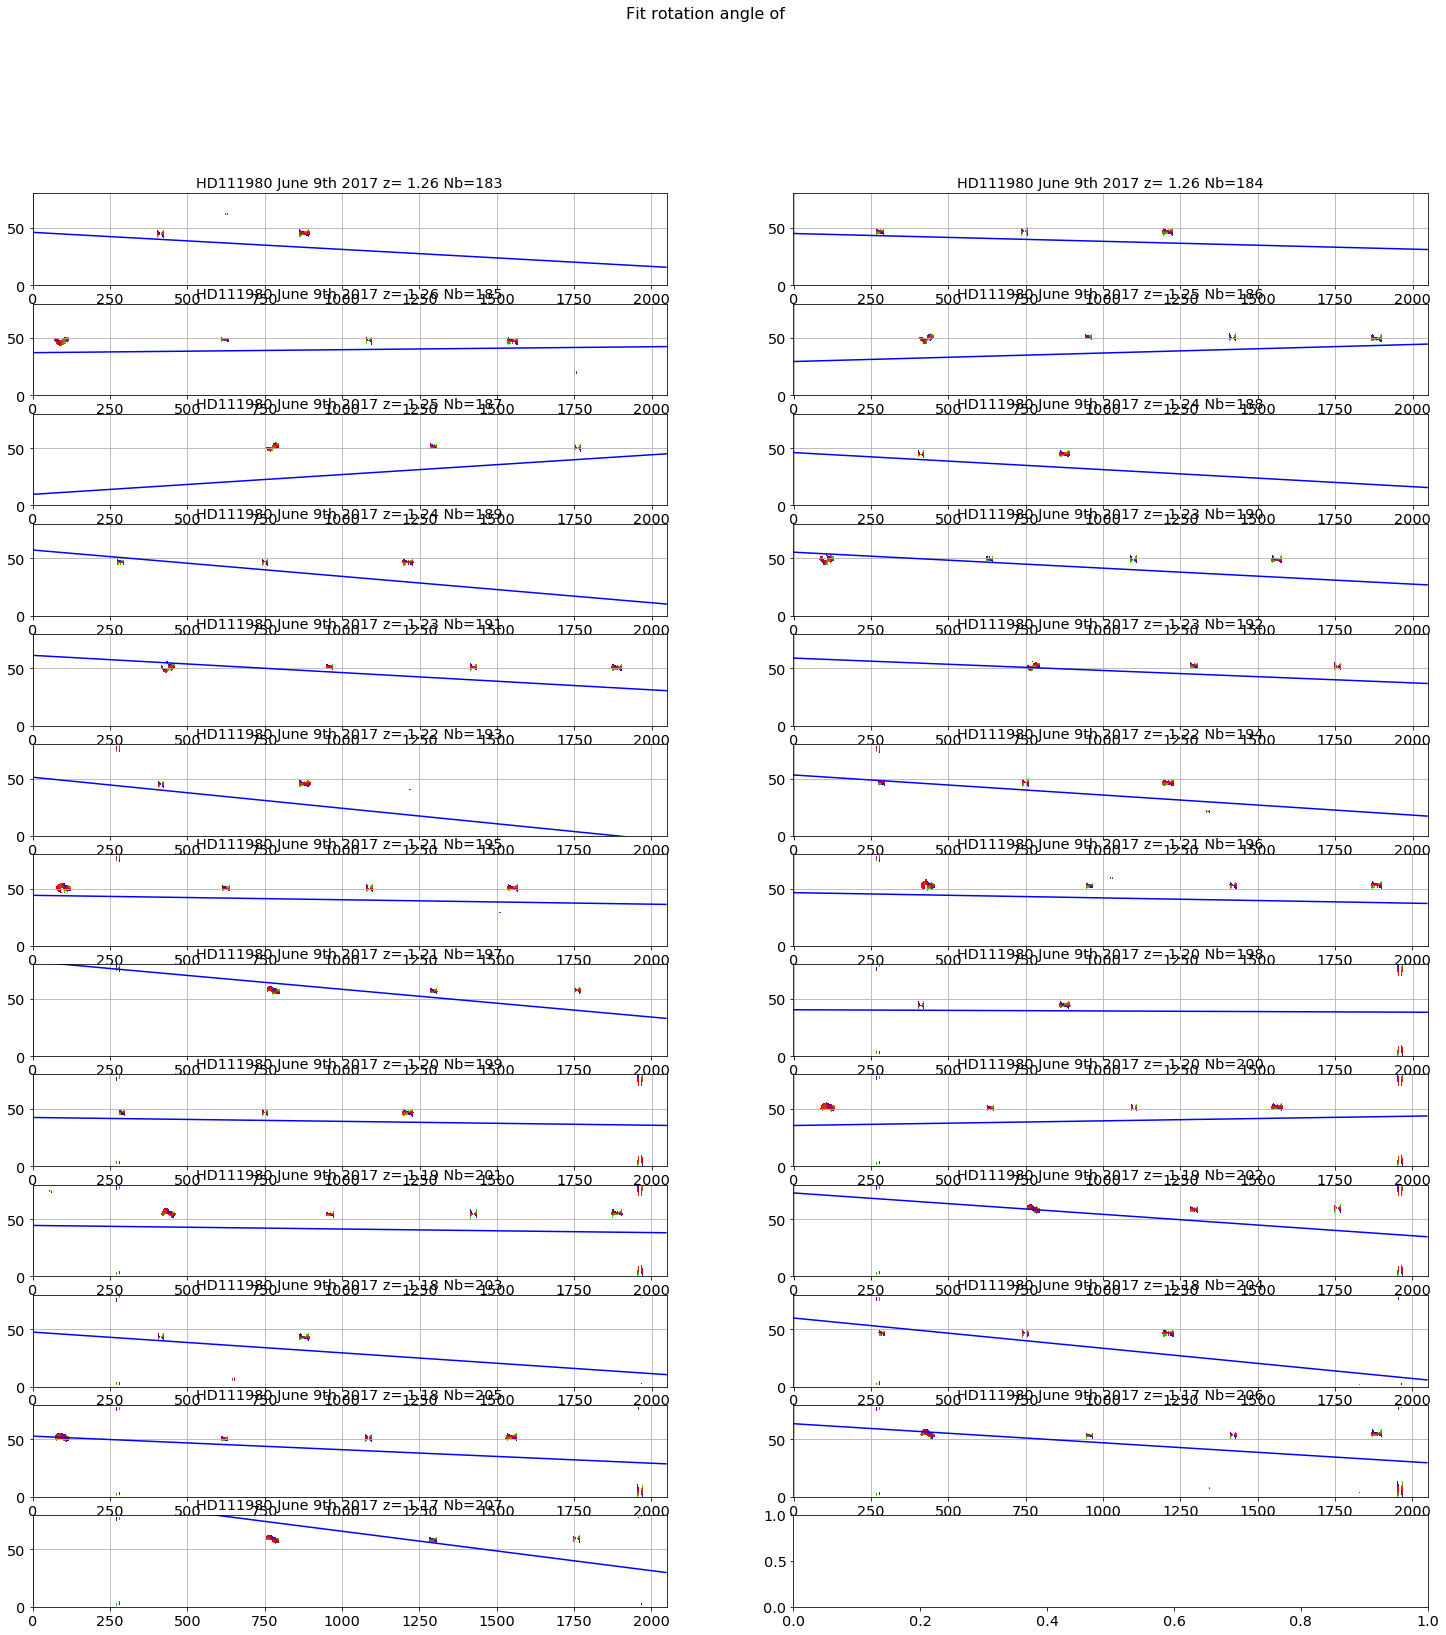

In [230]:
image_sel=np.copy(turned_images[sel])
y0=they0[sel]
x0=thex0[sel]

region=np.copy(image_sel[y0-width_cut:y0+width_cut,:])
data=np.copy(region)

ComputeRotationAngleHessian(turned_images,thex0,they0,all_titles,object_name)

## Analyse angles to find hologram center

### with line crossing

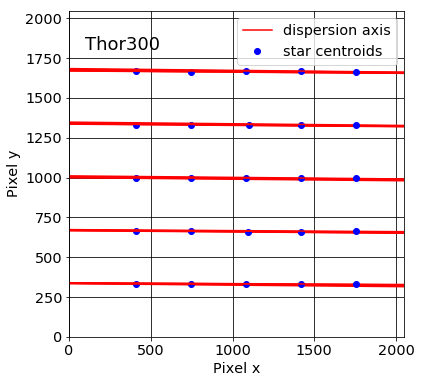

In [231]:
IMSIZE=2048
fig=plt.figure(figsize=(6,6))

for index in np.arange(len(all_theta)):
    y0=central_positions[index][0]
    x0=central_positions[index][1]
    x_new = np.linspace(0,IMSIZE, 50)
    y_new = y0 + (x_new-x0)*np.tan(all_theta[index]*np.pi/180.)
    if index==0 :
        plt.plot(x_new,y_new,'r-',label='dispersion axis')
        plt.plot(x0,y0,'bo',label='star centroids')
    else :
        plt.plot(x_new,y_new,'r-')
        plt.plot(x0,y0,'bo')
plt.xlim([0,IMSIZE])
plt.ylim([0,IMSIZE])
plt.grid(color='black', ls='solid')
plt.xlabel('Pixel x')
plt.ylabel('Pixel y')
plt.text(100,1800,holo_name,fontsize=18)
plt.legend()
plt.show()

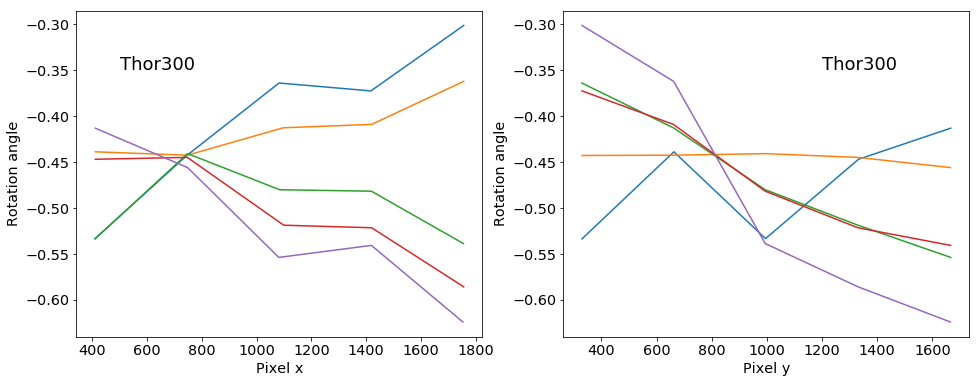

In [238]:
from scan_holo import *

def ShowRotationLines(all_angles,central_positions,centers=None):
    
    proj_x_lines, proj_y_lines = RotationLines(all_angles,central_positions)
    
    f, axarr = plt.subplots(1,2,figsize=(16,6))
    for i in range(5):
        axarr[0].plot(proj_x_lines[i][0],proj_x_lines[i][1])
    axarr[0].set_xlabel('Pixel x')
    axarr[0].set_ylabel('Rotation angle')
    axarr[0].text(500,-0.35,holo_name,fontsize=18)
    for i in reversed(range(5)):
        axarr[1].plot(proj_y_lines[i][0],proj_y_lines[i][1])
    axarr[1].set_xlabel('Pixel y')
    axarr[1].set_ylabel('Rotation angle')
    if centers is not None :
        axarr[0].scatter(centers[0][0],centers[0][1],s=200,color='red')
        axarr[1].scatter(centers[1][0],centers[1][1],s=200,color='red')
    axarr[1].text(1200,-0.35,holo_name,fontsize=18)
    plt.show()
    
    return(proj_x_lines,proj_y_lines)

proj_x_lines, proj_y_lines = ShowRotationLines(all_theta,central_positions)

Hologram center at x0 = 800.0 and y0 = 800.0 with average tilt of -0.4 degrees


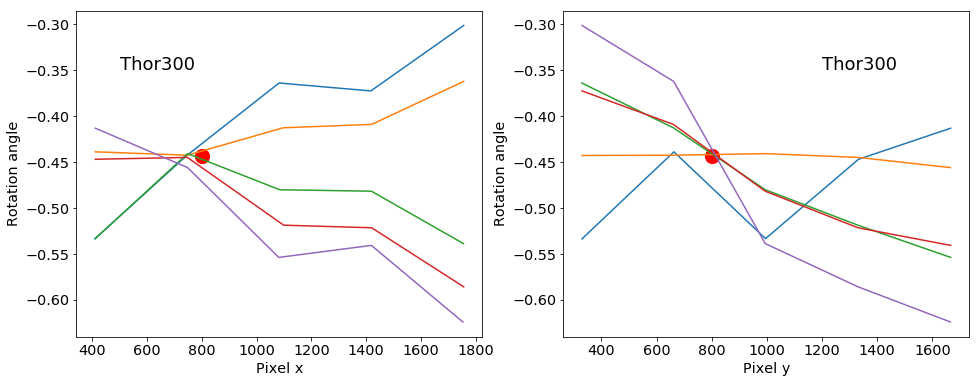

In [241]:
from scan_holo import *

x_center, y_center, theta0 = FindHoloCenter(all_theta,central_positions,proj_x_lines,proj_y_lines)
proj_x_lines, proj_y_lines = ShowRotationLines(all_theta,central_positions,centers=[[x_center,theta0],[y_center,theta0]])

### with surface analysis

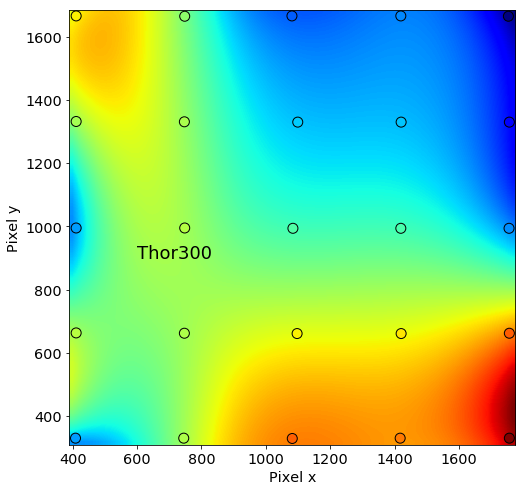

In [242]:
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D

y, x = np.array(central_positions).T
theta = interpolate.interp2d(x, y, all_theta, kind='cubic')
margin = 10

step = 1
xx = np.arange(np.min(x)-margin,np.max(x)+margin,step)
yy = np.arange(np.min(y)-margin,np.max(y)+margin,step)
z = theta(xx,yy)

fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=all_theta, s=100, cmap=cm.jet, marker='o', vmin=np.min(all_theta), vmax=np.max(all_theta),edgecolors='k')
plt.imshow(z, extent=[np.min(xx)-margin, np.max(xx)+margin, np.min(yy)-margin, np.max(yy)+margin],origin='lower',aspect='auto',cmap=cm.jet)
plt.xlabel('Pixel x')
plt.ylabel('Pixel y')
plt.text(600,900,holo_name,fontsize=18)
plt.show()

In [243]:
gx, gy = np.gradient(z)
grad = np.sqrt(gy**2+gx**2)
# on tronque les bords
grad = grad[margin:-margin,margin:-margin]
null_grad = np.where(np.isclose(grad,np.min(grad)))
x_center = xx[null_grad[1]]
y_center = yy[null_grad[0]]
theta_tilt = theta(x_center,y_center)

# le paramètre sigma permet de lisser le hessien
vmin, vmax = [-0.00001,0.00001]
Hxx, Hxy, Hyy = hessian_matrix(z, sigma=0.1, order = 'xy')
hessians = np.zeros_like(Hxx)
for i in range(hessians.shape[0]):
    for j in range(hessians.shape[1]):
        h = np.array([[Hxx[i,j],Hxy[i,j]],[Hxy[i,j],Hyy[i,j]]])
        hessians[i,j] = np.linalg.det(h)
        
print 'Minimum gradient of image:',np.min(grad[margin:-margin,margin:-margin])
print 'Hessian determinant at minimum:',hessians[null_grad][0],('(if negative: saddle point)')
print 'Hologram center at x0 = %.1f and y0 = %.1f with average tilt of %.1f degrees' % (x_center,y_center, theta_tilt)

Minimum gradient of image: 3.30697771529e-07
Hessian determinant at minimum: -7.58158844671e-13 (if negative: saddle point)
Hologram center at x0 = 1386.0 and y0 = 341.0 with average tilt of -0.4 degrees


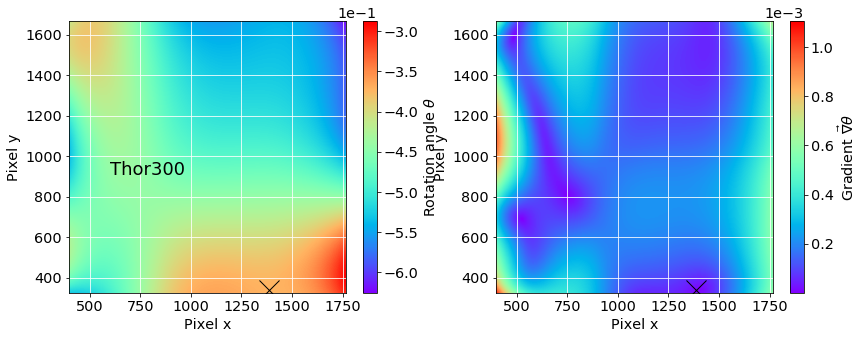

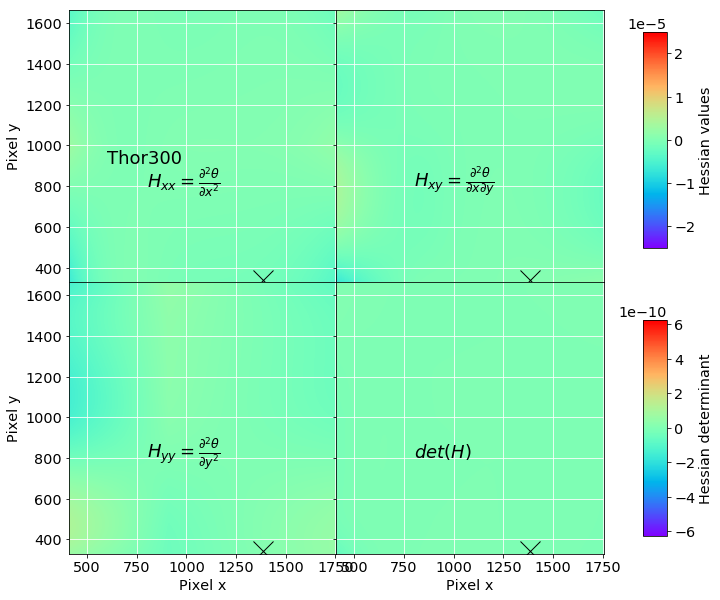

In [244]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,2,figsize=(13.85,5), sharex=True,sharey=False)
im = ax[0].imshow(z[margin:-margin,margin:-margin],origin='lower',cmap='rainbow', extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)])
im2 = ax[1].imshow(grad,origin='lower',cmap='rainbow', extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)])
ax[0].grid(color='white', ls='solid')
ax[1].grid(color='white', ls='solid')
ax[0].plot(x_center,y_center,'kx',markersize=20,label='Geometric center of hologram')
ax[1].plot(x_center,y_center,'kx',markersize=20,label='Geometric center of hologram')
ax[0].text(600,910,holo_name,fontsize=18)
fig.subplots_adjust(wspace=0.235)
#cbar_ax = fig.add_axes([0.45, 0.15, 0.03, 0.7])
cb = fig.colorbar(im,ax=ax[0])#, cax=cbar_ax)
cb.formatter.set_powerlimits((0, 0))
cb.update_ticks()
cb.set_label('Rotation angle $\\theta$') #,fontsize=16)
#cbar_ax2 = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cb2 = fig.colorbar(im2, ax=ax[1])#, cax=cbar_ax2)
cb2.formatter.set_powerlimits((0, 0))
cb2.update_ticks()
cb2.set_label('Gradient $\\vec{\\nabla} \\theta$') #,fontsize=16)
ax[0].set_xlabel('Pixel x')#,fontsize=14)
ax[1].set_xlabel('Pixel x')#,fontsize=14)
ax[0].set_ylabel('Pixel y')#,fontsize=14)
ax[1].set_ylabel('Pixel y')#,fontsize=14)
figfilename=os.path.join(dir_top_images,'rotation_map.pdf')
plt.savefig(figfilename)  
plt.show()

vmin, vmax = [-0.000025,0.000025]

fig, ax = plt.subplots(2,2,figsize=(11,10), sharex=True,sharey=True)
ax[0,0].imshow(Hxx[margin:-margin,margin:-margin],origin='lower',cmap='rainbow',aspect='auto',vmin=vmin,vmax=vmax, extent=[np.min(xx)+margin, np.max(xx)-margin, np.min(yy)+margin, np.max(yy)-margin])
ax[0,0].grid(color='white', ls='solid')
ax[0,0].text(800,800,'$H_{xx}=\\frac{\partial^2 \\theta}{\partial x^2}$',fontsize=18)
ax[0,0].text(600,910,holo_name,fontsize=18)
ax[0,0].plot(x_center,y_center,'kx',markersize=20,label='Geometric center of hologram')
ax[1,0].imshow(Hyy[margin:-margin,margin:-margin],origin='lower',cmap='rainbow',aspect='auto',vmin=vmin,vmax=vmax, extent=[np.min(xx)+margin, np.max(xx)-margin, np.min(yy)+margin, np.max(yy)-margin])
ax[1,0].grid(color='white', ls='solid')
ax[1,0].text(800,800,'$H_{yy}=\\frac{\partial^2 \\theta}{\partial y^2}$',fontsize=18)
ax[1,0].plot(x_center,y_center,'kx',markersize=20,label='Geometric center of hologram')
im = ax[0,1].imshow(Hxy[margin:-margin,margin:-margin],origin='lower',cmap='rainbow',aspect='auto',vmin=vmin,vmax=vmax, extent=[np.min(xx)+margin, np.max(xx)-margin, np.min(yy)+margin, np.max(yy)-margin])
ax[0,1].grid(color='white', ls='solid')
ax[0,1].plot(x_center,y_center,'kx',markersize=20,label='Geometric center of hologram')
im2 = ax[1,1].imshow(hessians[margin:-margin,margin:-margin],origin='lower',cmap='rainbow',aspect='auto',vmin=-vmin**2,vmax=vmax**2, extent=[np.min(xx)+margin, np.max(xx)-margin, np.min(yy)+margin, np.max(yy)-margin])
ax[1,1].grid(color='white', ls='solid')
ax[1,1].plot(x_center,y_center,'kx',markersize=20,label='Geometric center of hologram')
ax[0,1].text(800,800,'$H_{xy}=\\frac{\partial^2 \\theta}{\partial x \partial y}$',fontsize=18)
ax[1,1].text(800,800,'$det(H)$',fontsize=18)
ax[1,0].set_xlabel('Pixel x')#,fontsize=14)
ax[1,1].set_xlabel('Pixel x')#,fontsize=14)
ax[0,0].set_ylabel('Pixel y')#,fontsize=14)
ax[1,0].set_ylabel('Pixel y')#,fontsize=14)

fig.subplots_adjust(hspace =0, wspace=0, right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.03, 0.3])
cb = fig.colorbar(im, cax=cbar_ax)
cb.formatter.set_powerlimits((0, 0))
cb.update_ticks()
cb.set_label('Hessian values') #,fontsize=16)

cbar_ax2 = fig.add_axes([0.85, 0.15, 0.03, 0.3])
cb2 = fig.colorbar(im2, cax=cbar_ax2)
cb2.formatter.set_powerlimits((0, 0))
cb2.update_ticks()
cb2.set_label('Hessian determinant') #,fontsize=16)

figfilename=os.path.join(dir_top_images,'rotation_hessian_maps.pdf')
plt.savefig(figfilename)  
#fig.subplots_adjust(0,0,1,1,0,0)
plt.show()

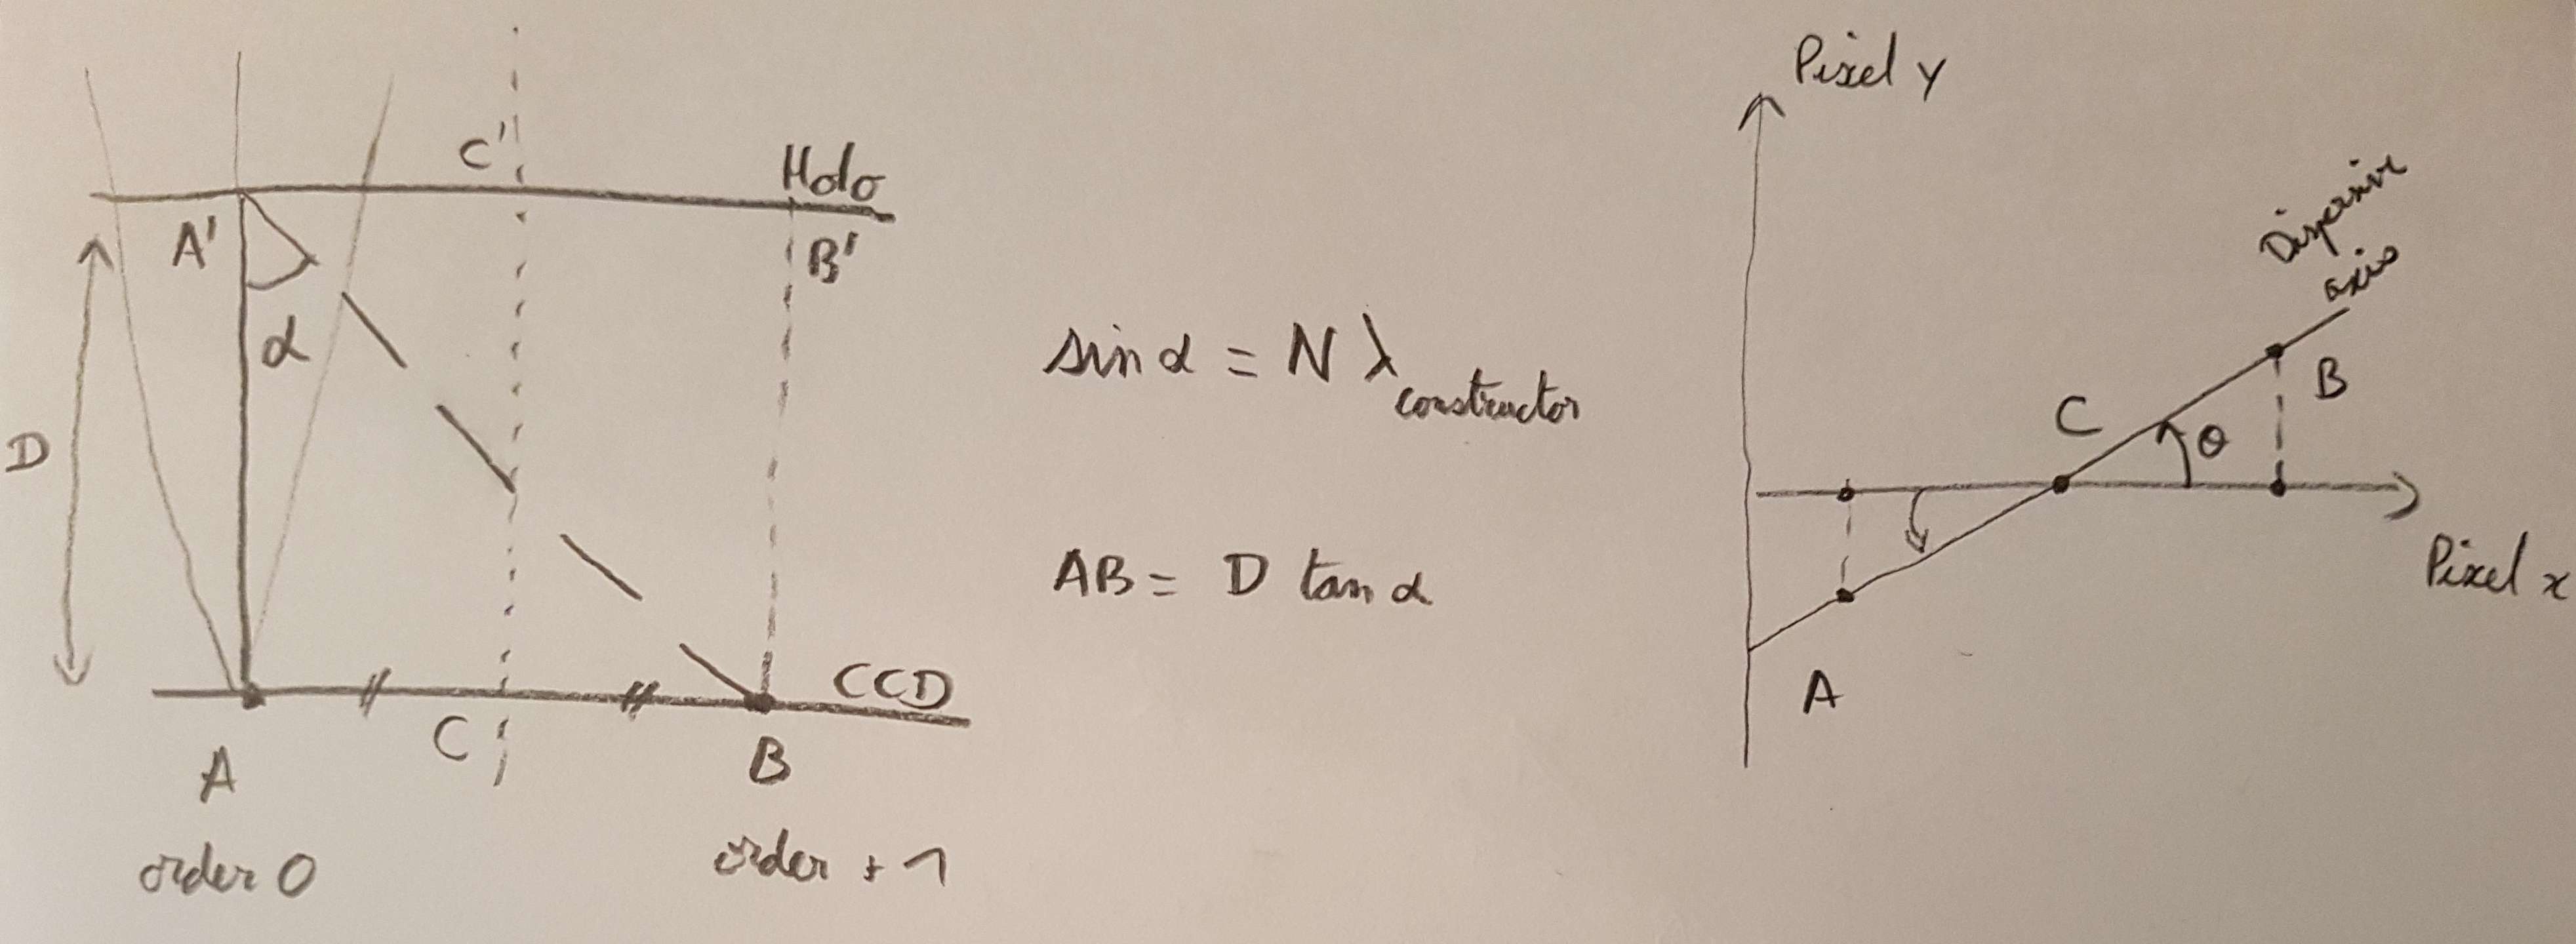

In [245]:
from IPython.display import Image
Image(filename='../../common_tools/pictures/hologram_centers.jpg')

In [246]:
from holo_specs import *

#xs, line1, line2 = neutral_lines(x_center,y_center,theta_tilt)
ronchi = build_ronchi(x_center,y_center,theta_tilt,grooves=0.4)

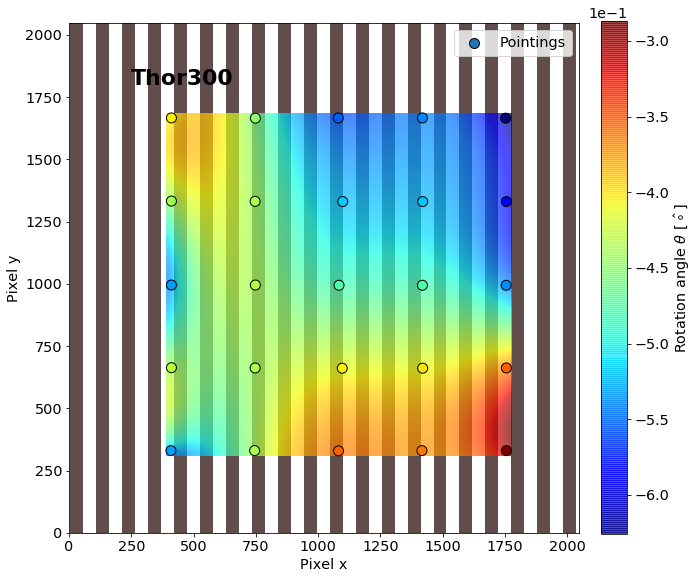

In [247]:
fig=plt.figure(figsize=(10,10))
plt.scatter(x, y, c=all_theta, label='Pointings',s=100, cmap=cm.jet, marker='o',vmin=np.min(all_theta), vmax=np.max(all_theta),edgecolors='k')
plt.imshow(ronchi,origin='lower', alpha=0.7, cmap=cm.pink)
im = plt.imshow(z, alpha=0.7,extent=[np.min(xx)-margin, np.max(xx)+margin, np.min(yy)-margin, np.max(yy)+margin],origin='lower',aspect='auto',cmap=cm.jet)
#plt.plot(xs,line1,'b-',label='Symmetric axes',lw=2)
#plt.plot(xs,line2,'b-',lw=2)
#plt.scatter(order0_position[0],order0_position[1],s=200,facecolor='red',label='Order 0 position')
#plt.scatter(order1_position[0],order1_position[1],s=200,facecolor='black',label='Order +1 position')
#plt.errorbar(0.5*IMSIZE+PLATE_CENTER_SHIFT_X/PIXEL2MM,0.5*IMSIZE+PLATE_CENTER_SHIFT_Y/PIXEL2MM,xerr=PLATE_CENTER_SHIFT_X_ERR/PIXEL2MM,yerr=PLATE_CENTER_SHIFT_Y_ERR/PIXEL2MM,marker='+',color='red',label='Plate center')
plt.xlabel('Pixel x')
plt.ylabel('Pixel y')
plt.text(250,1800,holo_name,weight='bold',fontsize=22)
plt.xlim([0,IMSIZE])
plt.ylim([0,IMSIZE])
plt.gca().set_aspect('equal', adjustable='box')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im,fraction=0.046, pad=0.04)#, cax=cbar_ax)
cb.formatter.set_powerlimits((0, 0))
cb.update_ticks()
cb.set_label('Rotation angle $\\theta$ [$\^\circ$]') #,fontsize=16)
plt.legend()
figfilename=os.path.join(dir_top_images,'grating_geometry.pdf')
plt.savefig(figfilename, bbox_inches='tight', rasterized=True, dpi=300)  
plt.show()

Thorlabs 300 grating is nearly flat as expected, but small turning along y0. Maybe due to rotation algorithm.

## Save results

In [248]:
#textfilename=os.path.join(outputdir,'star_centroids_rotations.txt')
#print textfilename
#out = []
#for index in range(len(all_theta)):
#    out.append([central_positions[index][0], central_positions[index][1], all_theta[index]])
#np.savetxt(textfilename,np.array(out),header="y_star x_star theta",fmt='%.3f')

#dirname = "../../common_tools/data/"+holo_name
#ensure_dir(dirname)
#print 'Save results in ',dirname
#np.savetxt(dirname+"/hologram_shape_lambdaplot%d.txt" % lambda_plot,holo)

#text = "#x_center y_center theta_tilt_in_degree\n" 
#text += "%.3f %.3f %.3f\n" % (x_center, y_center, theta_tilt)
#f=open(dirname+"/hologram_center.txt",'w')
#f.write(text)
#f.close()

#np.savetxt(dirname+'/rotation_angle_map.txt',z)
#np.savetxt(dirname+'/rotation_angle_map_x.txt',xx,fmt='%d')
#np.savetxt(dirname+'/rotation_angle_map_y.txt',yy,fmt='%d')

./rotated_fitsimages/star_centroids_rotations.txt


In [249]:
sorted_files

array(['cut_fitsimages/cutimg_20170609_183.fits',
       'cut_fitsimages/cutimg_20170609_184.fits',
       'cut_fitsimages/cutimg_20170609_185.fits',
       'cut_fitsimages/cutimg_20170609_186.fits',
       'cut_fitsimages/cutimg_20170609_187.fits',
       'cut_fitsimages/cutimg_20170609_188.fits',
       'cut_fitsimages/cutimg_20170609_189.fits',
       'cut_fitsimages/cutimg_20170609_190.fits',
       'cut_fitsimages/cutimg_20170609_191.fits',
       'cut_fitsimages/cutimg_20170609_192.fits',
       'cut_fitsimages/cutimg_20170609_193.fits',
       'cut_fitsimages/cutimg_20170609_194.fits',
       'cut_fitsimages/cutimg_20170609_195.fits',
       'cut_fitsimages/cutimg_20170609_196.fits',
       'cut_fitsimages/cutimg_20170609_197.fits',
       'cut_fitsimages/cutimg_20170609_198.fits',
       'cut_fitsimages/cutimg_20170609_199.fits',
       'cut_fitsimages/cutimg_20170609_200.fits',
       'cut_fitsimages/cutimg_20170609_201.fits',
       'cut_fitsimages/cutimg_20170609_202.fits',


In [250]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[1]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='rotimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [251]:
newfullfilenames

['./rotated_fitsimages/rotimg_20170609_183.fits',
 './rotated_fitsimages/rotimg_20170609_184.fits',
 './rotated_fitsimages/rotimg_20170609_185.fits',
 './rotated_fitsimages/rotimg_20170609_186.fits',
 './rotated_fitsimages/rotimg_20170609_187.fits',
 './rotated_fitsimages/rotimg_20170609_188.fits',
 './rotated_fitsimages/rotimg_20170609_189.fits',
 './rotated_fitsimages/rotimg_20170609_190.fits',
 './rotated_fitsimages/rotimg_20170609_191.fits',
 './rotated_fitsimages/rotimg_20170609_192.fits',
 './rotated_fitsimages/rotimg_20170609_193.fits',
 './rotated_fitsimages/rotimg_20170609_194.fits',
 './rotated_fitsimages/rotimg_20170609_195.fits',
 './rotated_fitsimages/rotimg_20170609_196.fits',
 './rotated_fitsimages/rotimg_20170609_197.fits',
 './rotated_fitsimages/rotimg_20170609_198.fits',
 './rotated_fitsimages/rotimg_20170609_199.fits',
 './rotated_fitsimages/rotimg_20170609_200.fits',
 './rotated_fitsimages/rotimg_20170609_201.fits',
 './rotated_fitsimages/rotimg_20170609_202.fits',


### Save outputfilename

In [252]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=turned_images[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

In [253]:
!ls -l rotated_fitsimages

total 174248
-rw-r--r--  1 jneveu  staff  3605760 11 jui 09:53 rotimg_20170609_183.fits
-rw-r--r--  1 jneveu  staff  3553920 11 jui 09:53 rotimg_20170609_184.fits
-rw-r--r--  1 jneveu  staff  3504960 11 jui 09:53 rotimg_20170609_185.fits
-rw-r--r--  1 jneveu  staff  3504960 11 jui 09:53 rotimg_20170609_186.fits
-rw-r--r--  1 jneveu  staff  3470400 11 jui 09:53 rotimg_20170609_187.fits
-rw-r--r--  1 jneveu  staff  3553920 11 jui 09:53 rotimg_20170609_188.fits
-rw-r--r--  1 jneveu  staff  3553920 11 jui 09:53 rotimg_20170609_189.fits
-rw-r--r--  1 jneveu  staff  3536640 11 jui 09:53 rotimg_20170609_190.fits
-rw-r--r--  1 jneveu  staff  3536640 11 jui 09:53 rotimg_20170609_191.fits
-rw-r--r--  1 jneveu  staff  3504960 11 jui 09:53 rotimg_20170609_192.fits
-rw-r--r--  1 jneveu  staff  3605760 11 jui 09:53 rotimg_20170609_193.fits
-rw-r--r--  1 jneveu  staff  3553920 11 jui 09:53 rotimg_20170609_194.fits
-rw-r--r--  1 jneveu  staff  3571200 11 jui 09:53 rotimg_20170609_195.fits
-rw-r--r--  